In [1]:
# pip install tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib as mpl
from tqdm import tqdm
from functools import cache
import time
from numba import jit
mpl.rcParams["figure.dpi"] = 240
mpl.rcParams["figure.figsize"] = (10,6)
r,sigma,T = 0.01,0.2,1

In [3]:
def BS_price(price,strike_price,r,sigma,T):
    d_positive = (np.log(price/strike_price)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d_negative = d_positive - sigma*np.sqrt(T)
    return price * norm.cdf(d_positive) - np.exp(-r*T)*norm.cdf(d_negative)*strike_price

# Attention! All the pricing function in this file is implemented as pricing the call option, if one want to calculate the put, please modify the code

$$
u=e^{\lambda \sigma \sqrt{\Delta t}}, \quad m=1, \quad d=e^{-\lambda \sigma \sqrt{\Delta t}}
$$
and
$$
q_u=\frac{1}{2 \lambda^2}+\frac{\left(r-\frac{\sigma^2}{2}\right) \sqrt{\Delta t}}{2 \lambda \sigma}, \quad q_m=1-\frac{1}{\lambda^2}, \quad q_d=\frac{1}{2 \lambda^2}-\frac{\left(r-\frac{\sigma^2}{2}\right) \sqrt{\Delta t}}{2 \lambda \sigma}
$$

# Parameters Settings

In [4]:
lambda_ = 1.1
N=100
dt = 1/N
price = 100
strike_price = 100
up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
down_factor = 1/up_factor
q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
q_m = 1-1/(lambda_**2)
q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
discounted_factor = np.exp(-r*dt)
probability = tuple([q_u,q_d,q_m])

# European Option

## Method 1: Loop over a matrix (higher effieient but coding is bit more complicated)

We can use matrix to represent the stock price 

$M= \begin{bmatrix}
S_0 & S_0u & S_0u^2 & S_0u^3 & \dots & S_0u^N \\
0 & S_0 & S_0u & S_0u^2 & \dots & S_0u^{N-1} \\
0 & S_0d & S_0 & S_0u^1 & \dots & \vdots \\
0 & 0 & S_0d & S_0 & \dots & S_0u \\
0 & 0 & S_0d^2 & S_0d & \dots & S_0 \\
0 & 0 & 0 & S_0d^2 & \dots & \vdots \\
\vdots & \vdots & \vdots & S_0d^3 & \ddots & S_0d^{N-1} \\
0 & 0 & 0 & \dots & \dots & S_0d^N
\end{bmatrix}  $

We have that (k,n)-th entry of M is (indexing staring from 0)
$$s^n_k = S_0u^{n}d^{k},n=0,1,...,N;k=0,1,...,2n,$$

therefore, the dynamic of stock price can be described as 
$$
\left\{
\begin{aligned}
&S_0u^{n+1}d^k = s^{n+1}_k\\
&S_0u^{n+1}d^{k+1} = s^{n+1}_{k+1}\\
&S_0u^{n+1}d^{k+2} = s^{n+1}_{k+2}
\end{aligned}
\right.
$$


We can consider $u$ as a rightward shift operator on the matrix, which shifts each element one index to the right, and $d$ as a downward shift operator, which shifts each element one index down. When we multiply these operators with matrix elements, the direction of the shift corresponds to the direction of the operator.

The matrix is in  $\mathbb{R}^{2N+1\times N+1}$, the column represent the time step, the row reprent the price calculatred based on the previous row. At each column $j$, the first $2j+1$ elements are non-zero.

Let $V$ be the matrix of the price of option and $V_k^n = V(s^n_k)$, we have the following rule:
$$V^n_k=e^{-r\Delta t}\left[q_uV^{n+1}_k + q_mV^{n+1}_{k+1}+q_dV^{n+1}_{k+2}\right]$$

In [5]:
N,lambda_,price,strike_price = 10000,1.25,100,100
@jit
def trinomial_matrix_price(N,lambda_,price,strike_price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    down_factor = 1/up_factor
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    price_matrix = np.zeros((2*N+1,N+1)) # stock price
    V = np.zeros((2*N+1,N+1)) # option price
    # genreate stock price
    for c in range(N+1):
        price_matrix[:2*c+1,c] = price * (up_factor**c) * (down_factor**np.arange(0,2*c+1))
    # final payoff
    V[:,-1] = np.maximum(price_matrix[:,-1]-strike_price,0)
    for col in range(N-1,-1,-1):
        V[:2*col+1,col] = discounted_factor*(q_u * V[0:2*col+1,col+1] + q_m * V[1:2*col+2,col+1] + q_d * V[2:2*col+3,col+1])
    return V[0,0]

### Q1 (b): Varying N using method 1

In [6]:
results = []
x = range(500,10000,500)
for N in tqdm(x):
    results.append(trinomial_matrix_price(N,lambda_,price,strike_price,sigma,r))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:31<00:00,  1.66s/it]


Text(0, 0.5, 'Price')

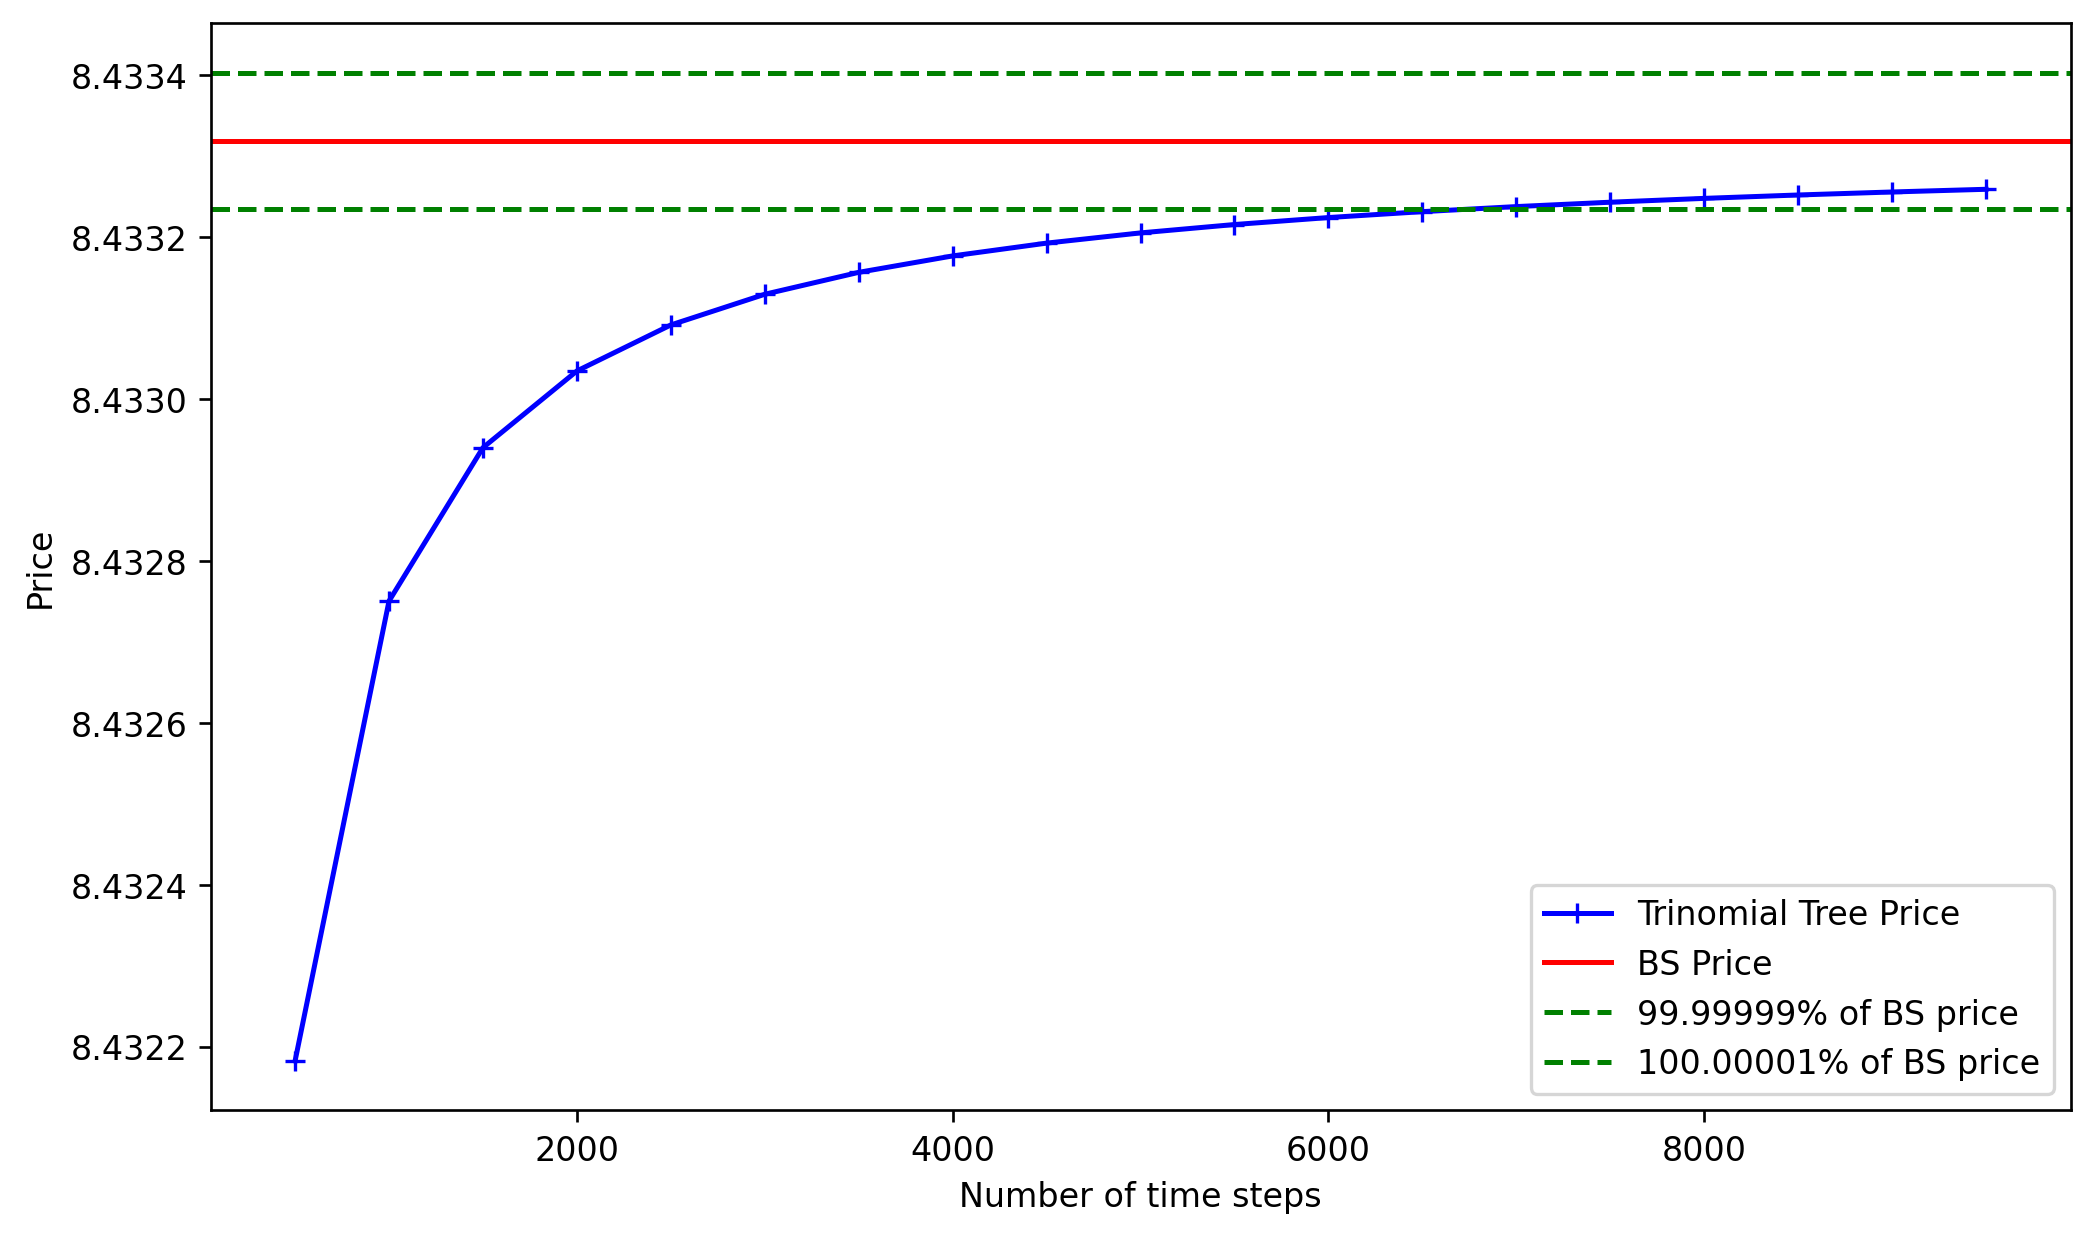

In [7]:
plt.plot(x,results,'b+-')
plt.axhline(y = BS_price(price,strike_price,r,sigma,T), color = 'r', linestyle = '-')
plt.axhline(y = BS_price(price,strike_price,r,sigma,T)*0.99999, color = 'g', linestyle = '--')
plt.axhline(y = BS_price(price,strike_price,r,sigma,T)*1.00001, color = 'g', linestyle = '--')
plt.legend(["Trinomial Tree Price","BS Price","99.99999% of BS price","100.00001% of BS price"])
plt.xlabel("Number of time steps")
plt.ylabel("Price")
# plt.savefig("./文件名.jpg")

### Q1 (b): Varying $\lambda$ using method 1

The cell below may take 2 minutes to run

In [8]:
results1 = []
results2 = []
x = range(500,10000,501)
for lambda_ in [1,1.25,1.5,1.75]:
    results1 = []
    for N in tqdm(x):
        results1.append(trinomial_matrix_price(N,lambda_,price,strike_price,sigma,r))
    results2.append(results1)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:30<00:00,  1.60s/it]


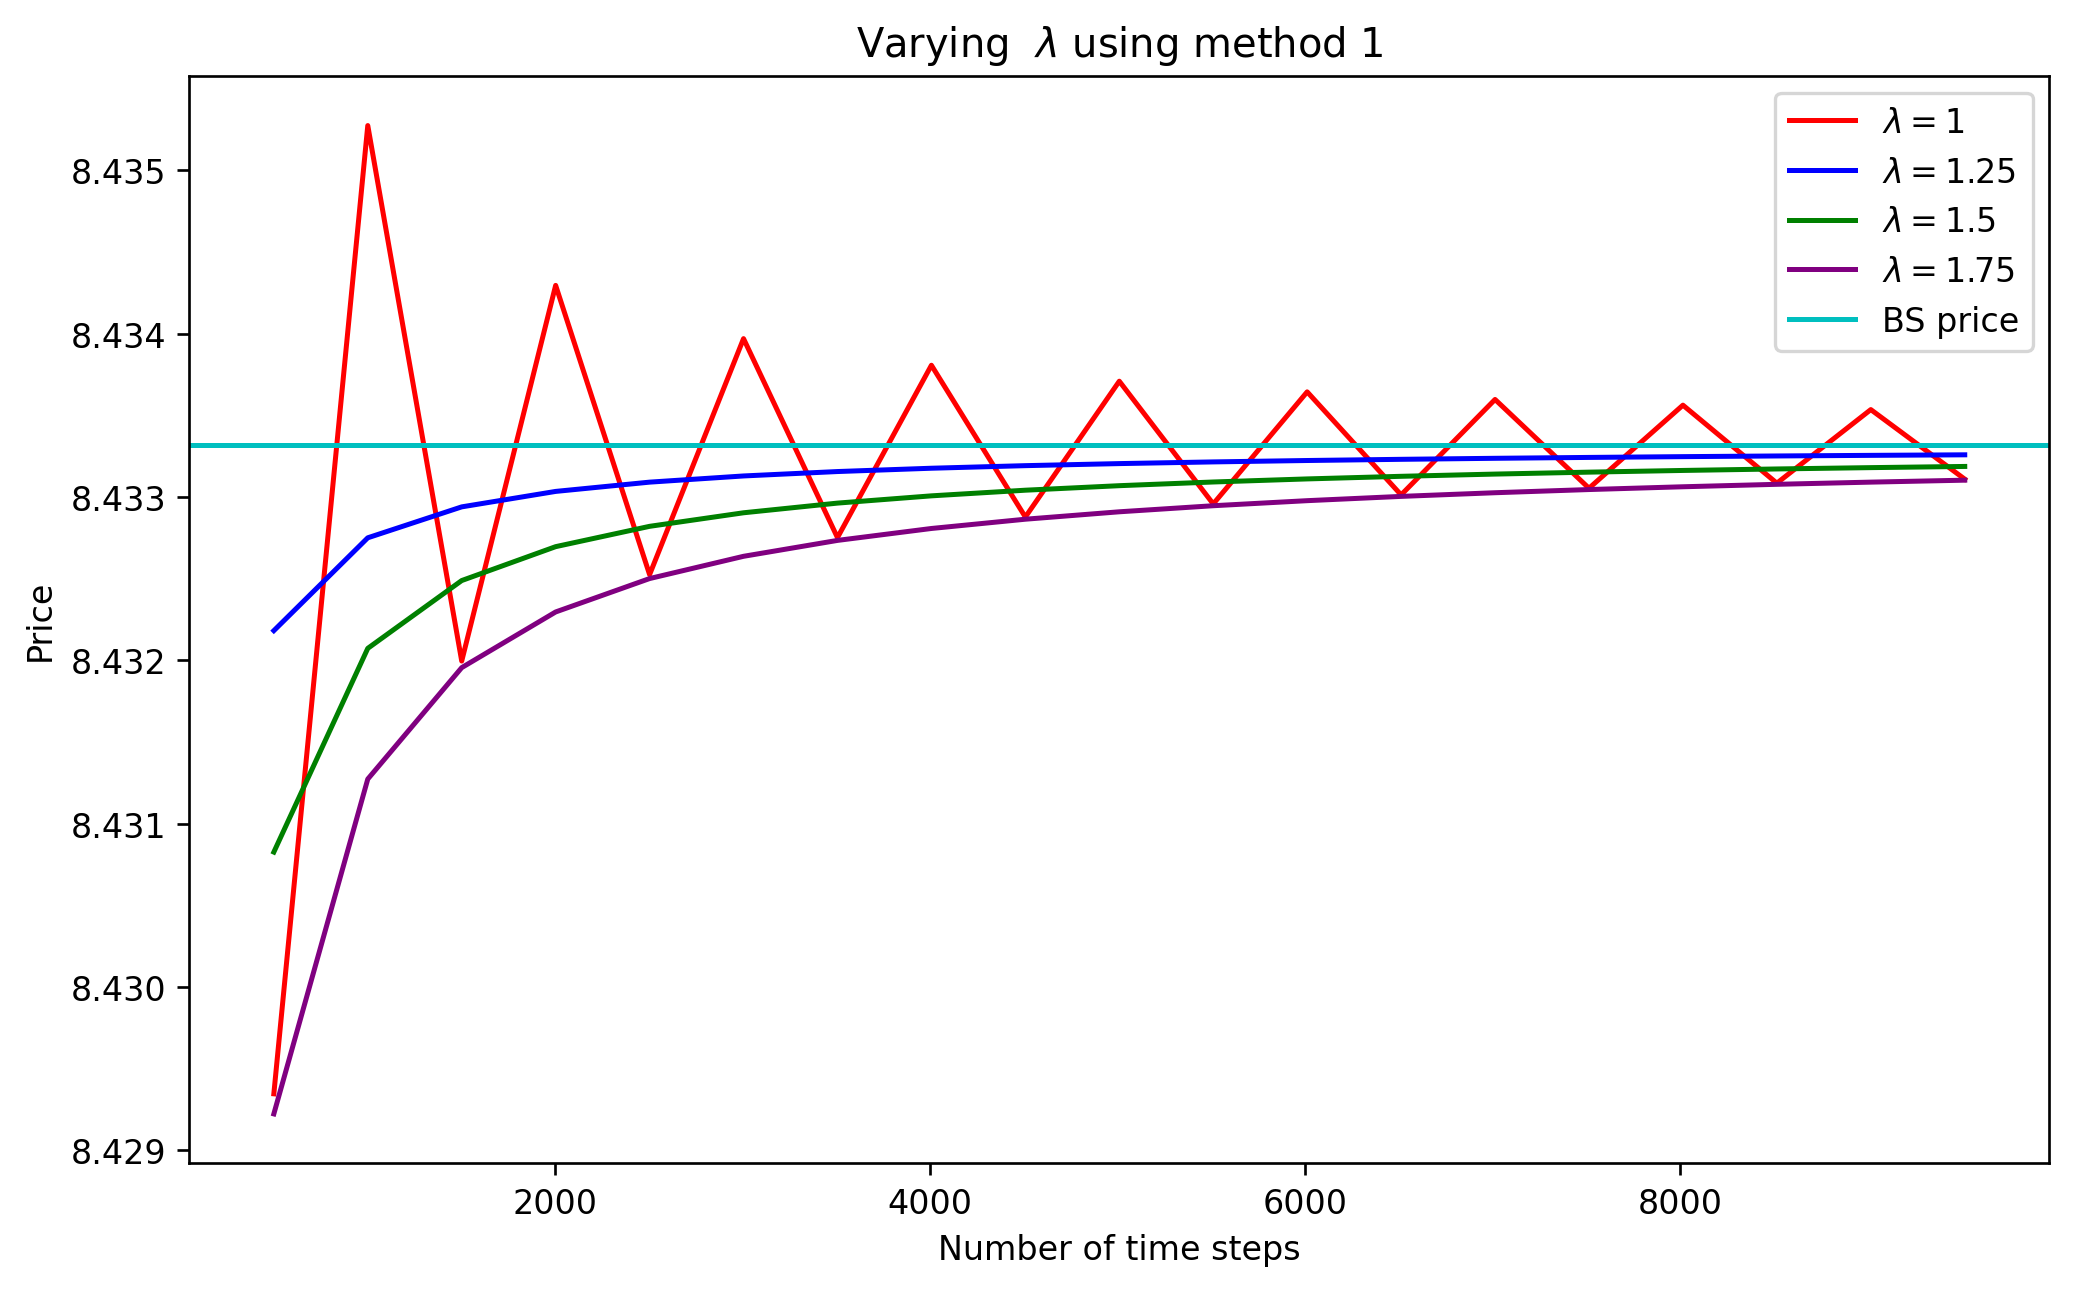

In [9]:
colors = ['red', 'blue', 'green', 'purple']
labels = [r'$\lambda = 1$', r'$\lambda = 1.25$', r'$\lambda = 1.5$', r'$\lambda = 1.75$']
for i in range(4):
    plt.plot(x, results2[i], color=colors[i], label=labels[i])
plt.axhline(y = BS_price(price,strike_price,r,sigma,T), color = 'c', linestyle = '-',label="BS price")
plt.title(r'Varying  $\lambda$ using method 1')
plt.xlabel('Number of time steps')
plt.ylabel('Price')
plt.legend()
# plt.savefig("./文件名.jpg")

### Q(1) b: Comment on changing in $S_0$

Talk about $\Delta = \dfrac{\partial C}{\partial S_0}$, where $C$ is the option price

### Q(1) c:

In [10]:
results1 = []
results2 = []
N = 500
for lambda_ in [1,1.25,1.5,1.75]:
    results1 = []
    for price in tqdm(range(70,131,1)):
        results1.append(trinomial_matrix_price(N,lambda_,price,strike_price,sigma,r))
    results2.append(results1)

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 222.87it/s]


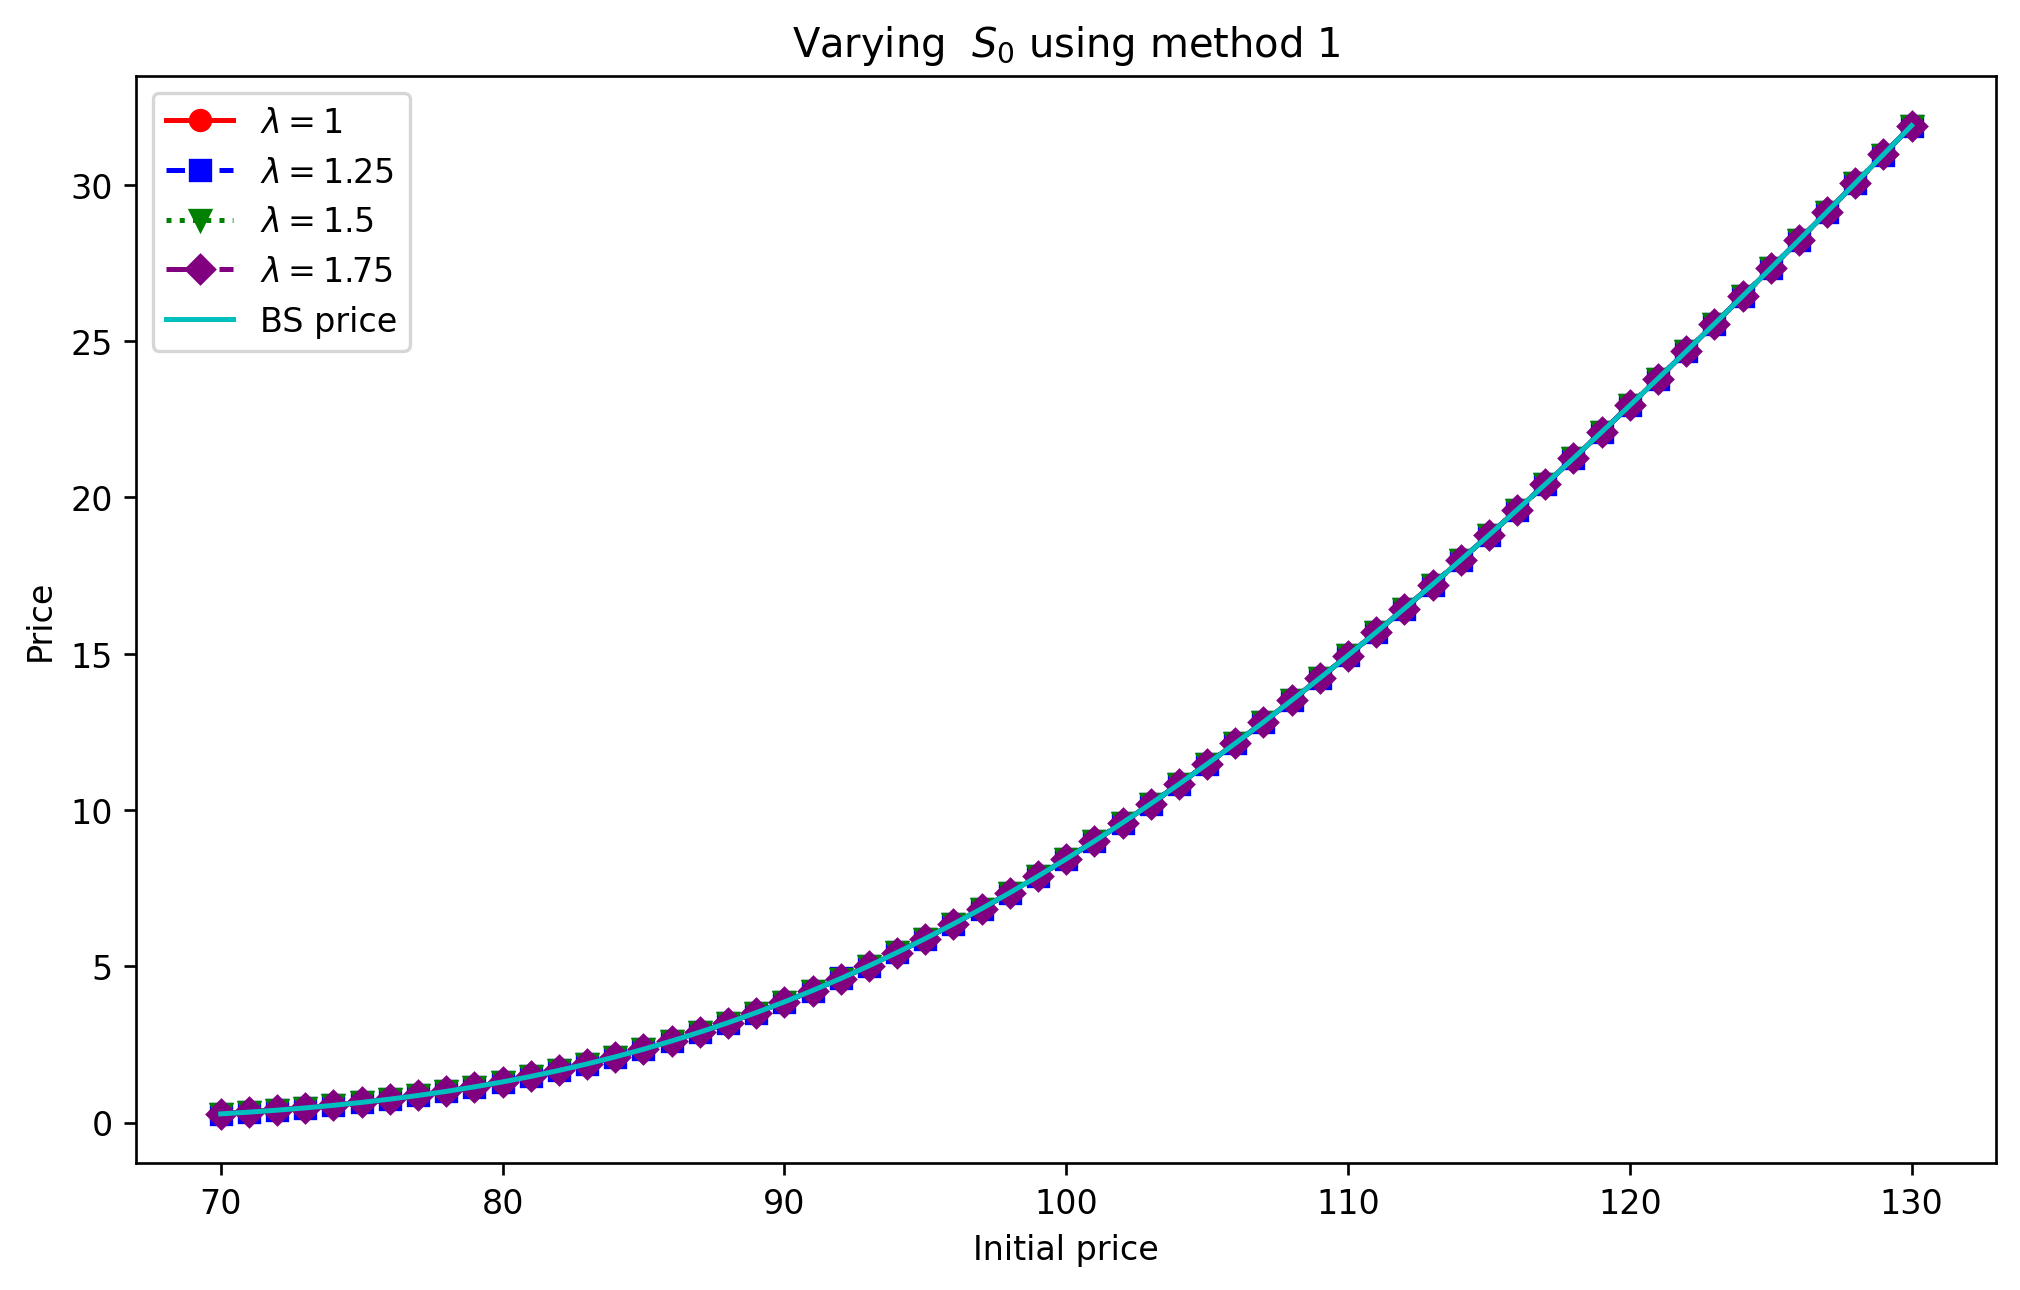

In [11]:
styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'v', 'D']
colors = ['red', 'blue', 'green', 'purple']
labels = [r'$\lambda = 1$', r'$\lambda = 1.25$', r'$\lambda = 1.5$', r'$\lambda = 1.75$']
for i in range(4):
    plt.plot(range(70,131,1), results2[i], color=colors[i], label=labels[i],linestyle=styles[i], marker=markers[i])
plt.plot(range(70,131,1),[BS_price(price,strike_price,r,sigma,T) for price in range(70,131,1)], color = 'c', linestyle = '-',label="BS price")
plt.title(r'Varying  $S_0$ using method 1')
plt.xlabel('Initial price')
plt.ylabel('Price')
plt.legend()
# plt.savefig("./文件名.jpg")

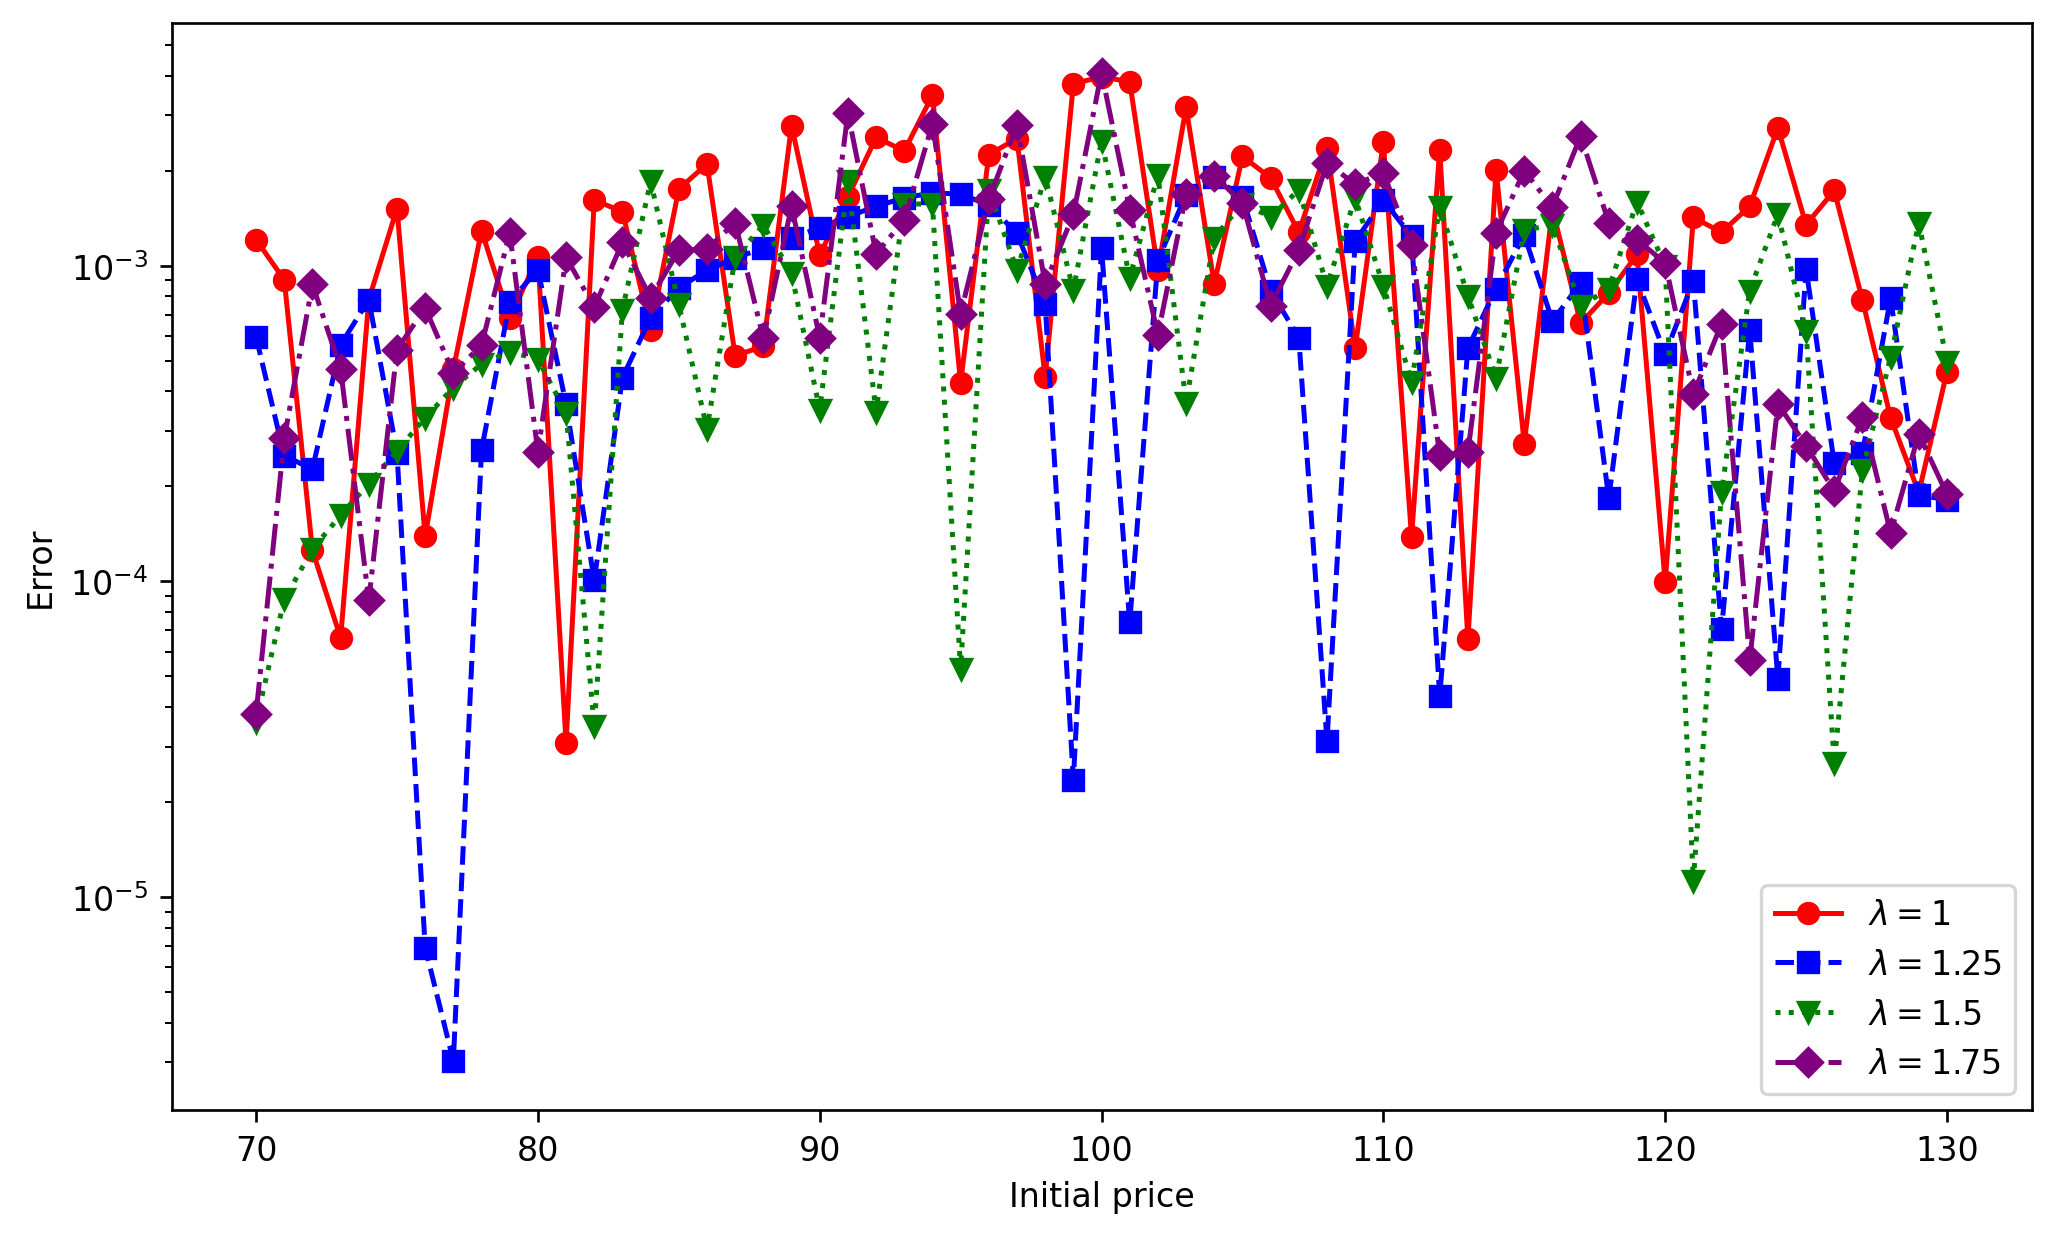

In [12]:
styles = ['-', '--', ':', '-.']
markers = ['o', 's', 'v', 'D']
colors = ['red', 'blue', 'green', 'purple']
labels = [r'$\lambda = 1$', r'$\lambda = 1.25$', r'$\lambda = 1.5$', r'$\lambda = 1.75$']
y = [BS_price(price,strike_price,r,sigma,T) for price in range(70,131,1)]
for i in range(4):
    plt.semilogy(range(70,131,1), abs(np.array(results2[i])-y), color=colors[i], label=labels[i],linestyle=styles[i], marker=markers[i])
plt.xlabel('Initial price')
plt.ylabel('Error')
plt.legend()
# plt.savefig("./文件名.jpg")

In [13]:
average = []
for i in range(4):
    average.append(np.mean(abs(np.array(results2[i])-y)))
np.argmin(average) # 1.25 is the element whose index is 1

1

In [14]:
# optimal lambda
lambda_ = 1.25

## Method 2: Trinomial Tree Recursion (easy to implement but not efficient)

A tree is a data structure that is typically constructed through recursion, which enables us to build a trinomial pricing tree using recursion and memoization to enhance the algorithm's efficiency. The implementation code is straightforward.

Even with the use of memoized depth-first search to construct this trinomial tree, its time complexity increases exponentially. Therefore, when N is small, such as 500, the efficiency of the code is already low. However, it helps us understand the essence of using tree structures for pricing. We will demonstrate how this method can be used to solve Q1 and will not use it for subsequent problems.

In [15]:
# parameter setting
N=200
dt = 1/N
price = 100
strike_price = 100
up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
down_factor = 1/up_factor
q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
q_m = 1-1/(lambda_**2)
q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
discounted_factor = np.exp(-r*dt)
probability = tuple([q_u,q_d,q_m])
@cache
def trinomial_tree_price(price, N, up_factor, down_factor, probability, strike_price,discounted_factor):
    probability = np.array(probability)
    if N == 0:
        return max(0, price-strike_price )
    else:
        up = trinomial_tree_price(round(price * up_factor,8), N - 1, up_factor, down_factor, tuple(probability),strike_price,discounted_factor)
        down = trinomial_tree_price(round(price * down_factor,8), N - 1, up_factor, down_factor, tuple(probability),strike_price,discounted_factor)
        unchanged = trinomial_tree_price(round(price,8), N - 1, up_factor, down_factor, tuple(probability),strike_price,discounted_factor)
        return np.sum(probability * np.array([up,down,unchanged])) * discounted_factor

### Q1 (b): Varying N using method 2

#### Warning: the cell below may take 1 minute to run

In [16]:
results = []
for N in tqdm(range(50,550,25)):
    lambda_ = 1.1
    dt = 1/N
    price = 100
    strike_price = 100
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    down_factor = 1/up_factor
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    probability = tuple([q_u,q_d,q_m])
    trinomial_tree_price.cache_clear()
    results.append(trinomial_tree_price(price, N, up_factor, down_factor, probability, strike_price,discounted_factor))
    trinomial_tree_price.cache_clear()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  3.33s/it]


Text(0, 0.5, 'Price')

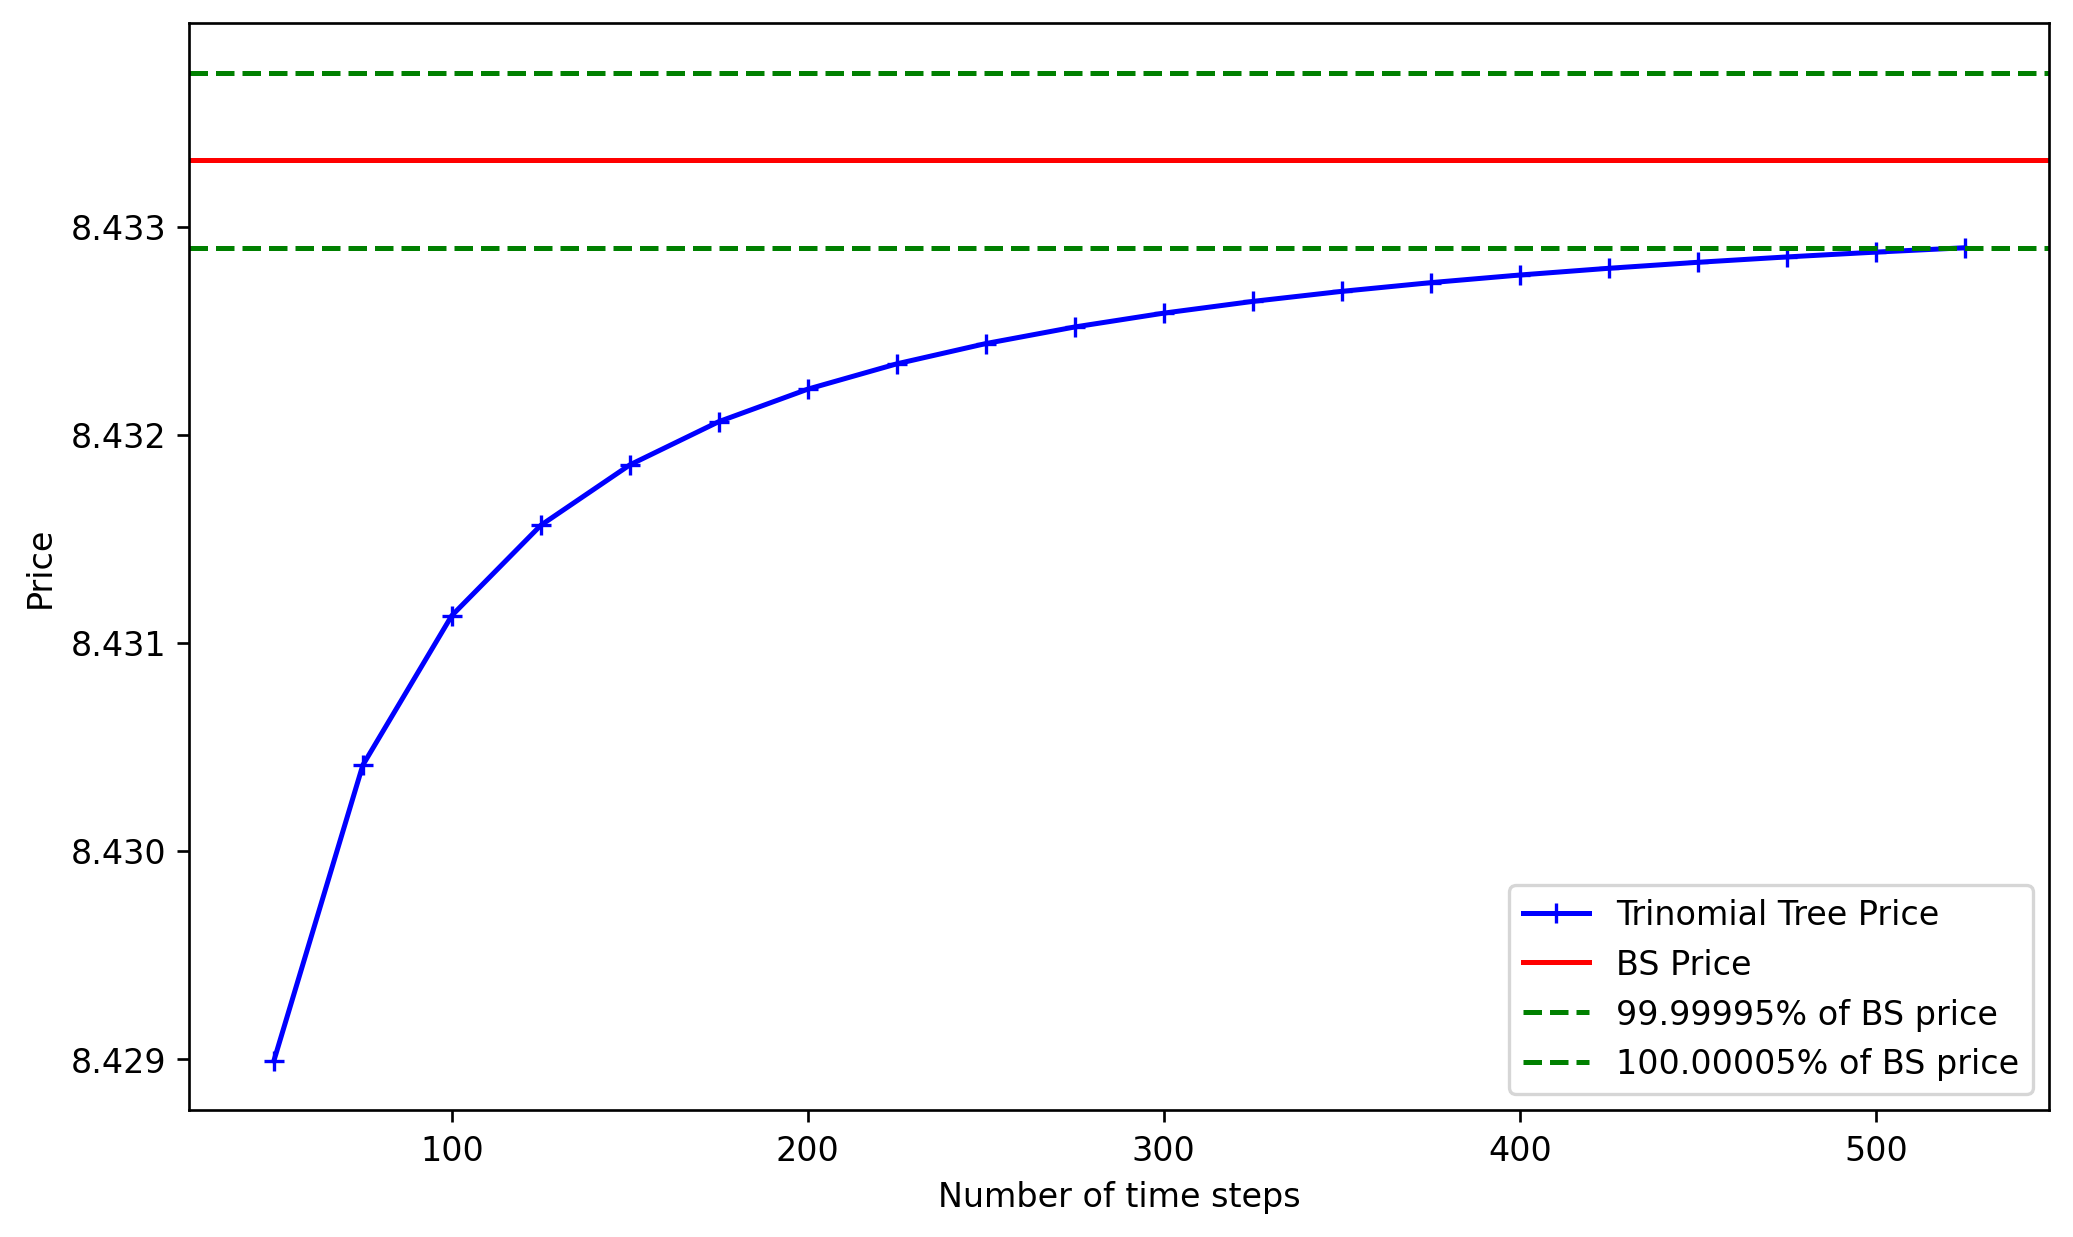

In [17]:
plt.plot(range(50,550,25),results,'b+-')
plt.axhline(y = BS_price(price,strike_price,r,sigma,T), color = 'r', linestyle = '-')
plt.axhline(y = BS_price(price,strike_price,r,sigma,T)*0.99995, color = 'g', linestyle = '--')
plt.axhline(y = BS_price(price,strike_price,r,sigma,T)*1.00005, color = 'g', linestyle = '--')
plt.legend(["Trinomial Tree Price","BS Price","99.99995% of BS price","100.00005% of BS price"])
plt.xlabel("Number of time steps")
plt.ylabel("Price")

### Q1 (b): Varying $\lambda$ using method 2

#### Warning: the cell below may take 2 minute to run

### Q(1) c using method 2:

#### Warning: the cell below may take 8 minute to run

# American Option

# Q1 (a)

just change the payoff matrix and dynamically calculate the price based on algorithm in the notes

## Q2 (b)

In [18]:
N,lambda_,strike_price = 500,1.25,100
@jit
def trinomial_matrix_price_call(N,lambda_,price,strike_price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    down_factor = 1/up_factor
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    price_matrix = np.zeros((2*N+1,N+1)) # stock price
    V = np.zeros((2*N+1,N+1)) # option price
    # generate the stock price 
    for c in range(N+1):
        price_matrix[:2*c+1,c] = price * (up_factor**c) * (down_factor**np.arange(0,2*c+1))
    # final payoff
    V[:,-1] = np.maximum(price_matrix[:,-1]-strike_price,0)
    for col in range(N-1,-1,-1):
        V[:2*col+1,col] = np.maximum(discounted_factor*(q_u * V[0:2*col+1,col+1] + q_m * V[1:2*col+2,col+1] + q_d * V[2:2*col+3,col+1])
                                    ,price_matrix[:2*col+1,col]-strike_price)
    return V[0,0]

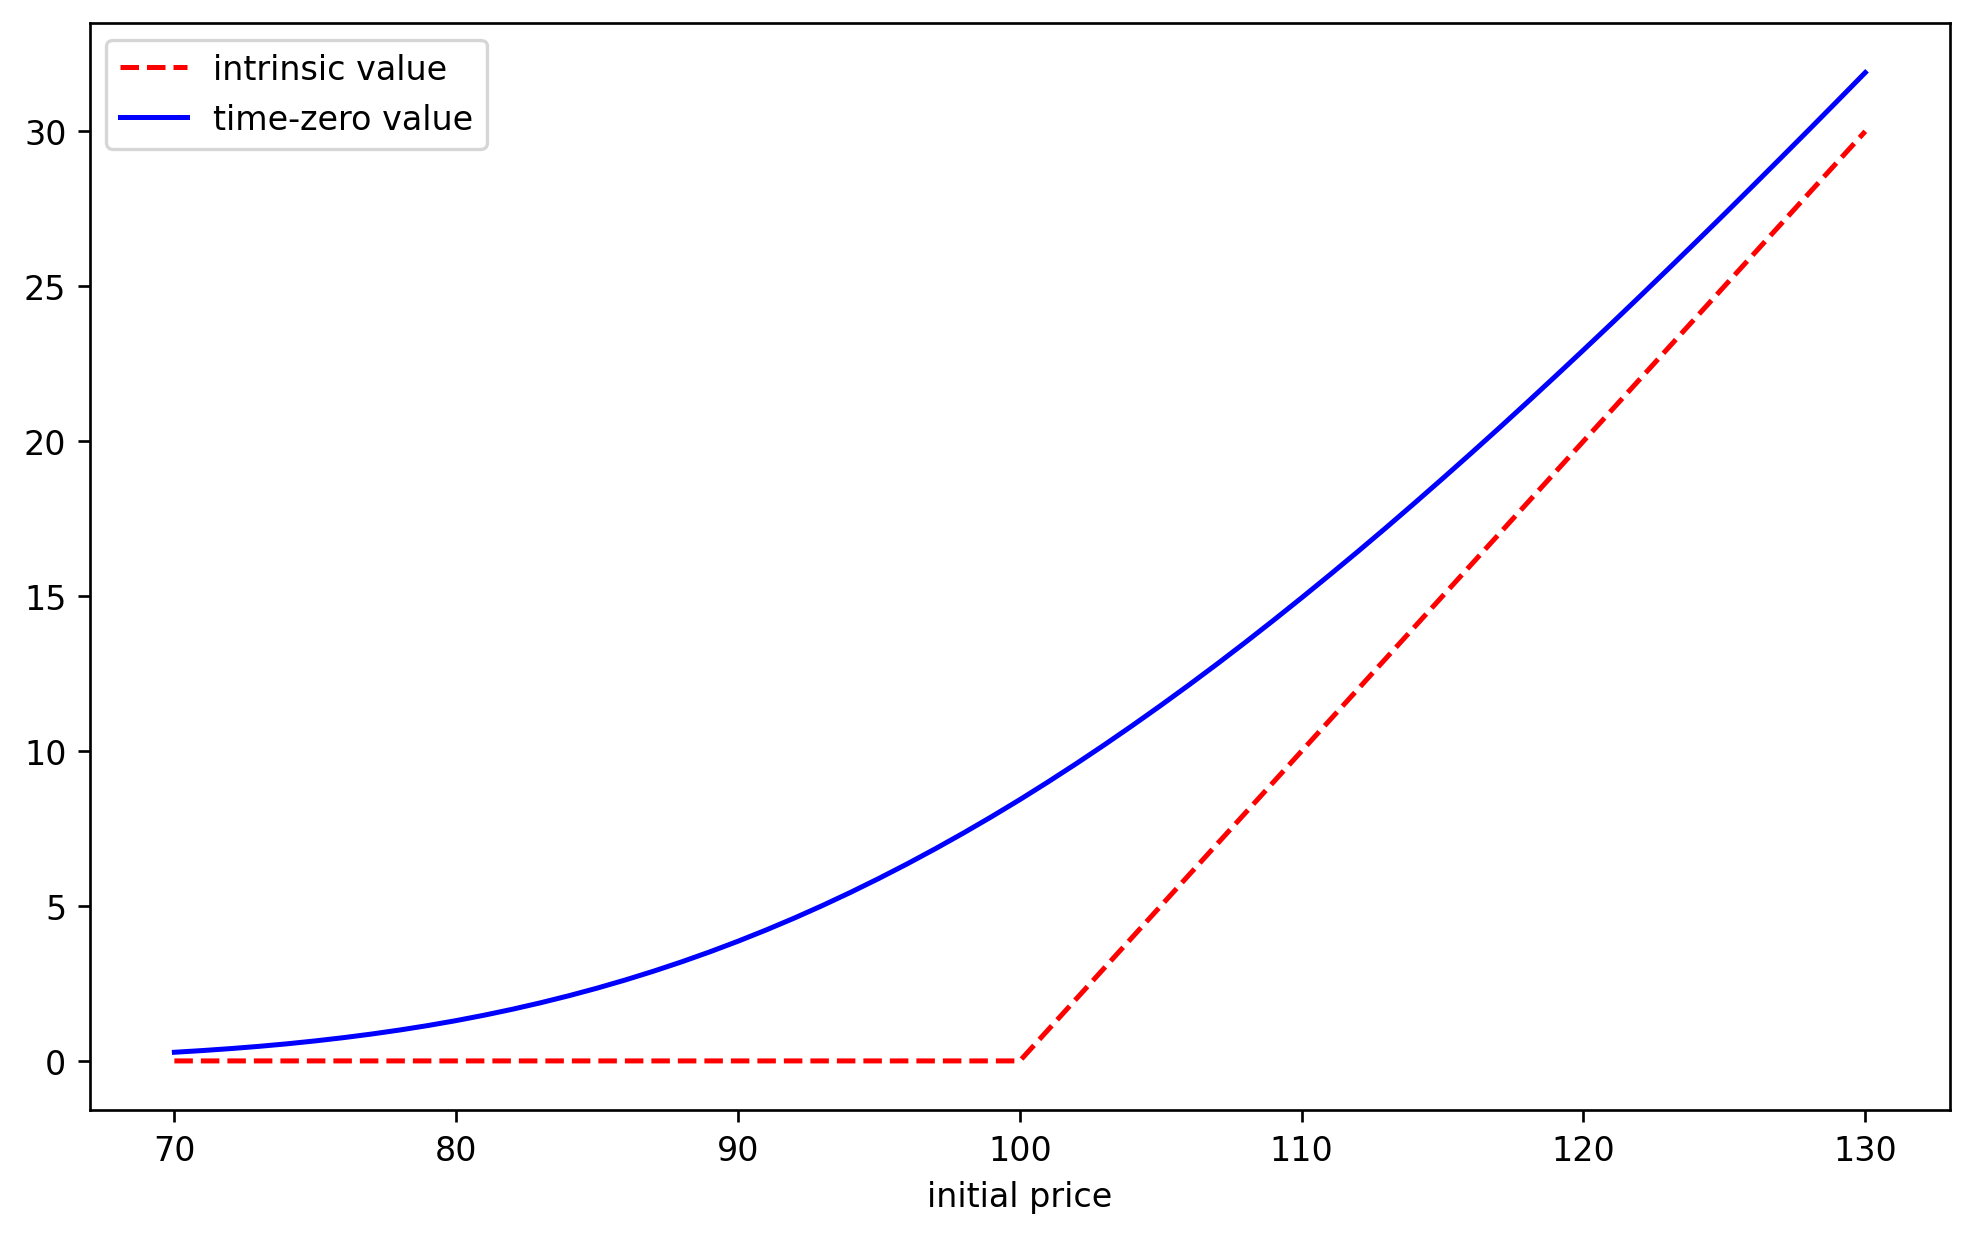

In [19]:
conitnuation_value = []
intrinsic_value = [max(i-strike_price,0) for i in range(70,131)]
for price in range(70,131):
    conitnuation_value.append(trinomial_matrix_price_call(N,lambda_,price,strike_price,sigma,r))
plt.plot(range(70,131),intrinsic_value,'r--',label = "intrinsic value")
plt.plot(range(70,131),conitnuation_value,'b-',label = "time-zero value")
plt.xlabel("initial price")
plt.legend()
# plt.savefig("./1.2.b.call.jpg")

### Discussion on optimal exercise strategy(refer to the report)

## Q2 (c)

## Method 1 for American put option

In [20]:
N,lambda_,price,strike_price = 500,1.25,100,100
@jit
def trinomial_matrix_price_put(N,lambda_,price,strike_price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    down_factor = 1/up_factor
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    price_matrix = np.zeros((2*N+1,N+1)) # stock price
    V = np.zeros((2*N+1,N+1)) # option price
    for c in range(N+1):
        price_matrix[:2*c+1,c] = price * (up_factor**c) * (down_factor**np.arange(0,2*c+1))
    V[:,-1] = np.maximum(-1*(price_matrix[:,-1]-strike_price),0)
    for col in range(N-1,-1,-1):
        V[:2*col+1,col] = np.maximum(discounted_factor*(q_u * V[0:2*col+1,col+1] + q_m * V[1:2*col+2,col+1] + q_d * V[2:2*col+3,col+1])
                                    ,-1*(price_matrix[:2*col+1,col]-strike_price))
    return V[0,0]

In [21]:
@jit
def trinomial_matrix_price_europut(N,lambda_,price,strike_price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    down_factor = 1/up_factor
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    price_matrix = np.zeros((2*N+1,N+1)) # stock price
    V = np.zeros((2*N+1,N+1)) # option price
    # genreate stock price
    for c in range(N+1):
        price_matrix[:2*c+1,c] = price * (up_factor**c) * (down_factor**np.arange(0,2*c+1))
    # final payoff
    V[:,-1] = np.maximum(-(price_matrix[:,-1]-strike_price),0)
    for col in range(N-1,-1,-1):
        V[:2*col+1,col] = discounted_factor*(q_u * V[0:2*col+1,col+1] + q_m * V[1:2*col+2,col+1] + q_d * V[2:2*col+3,col+1])
    return V[0,0]

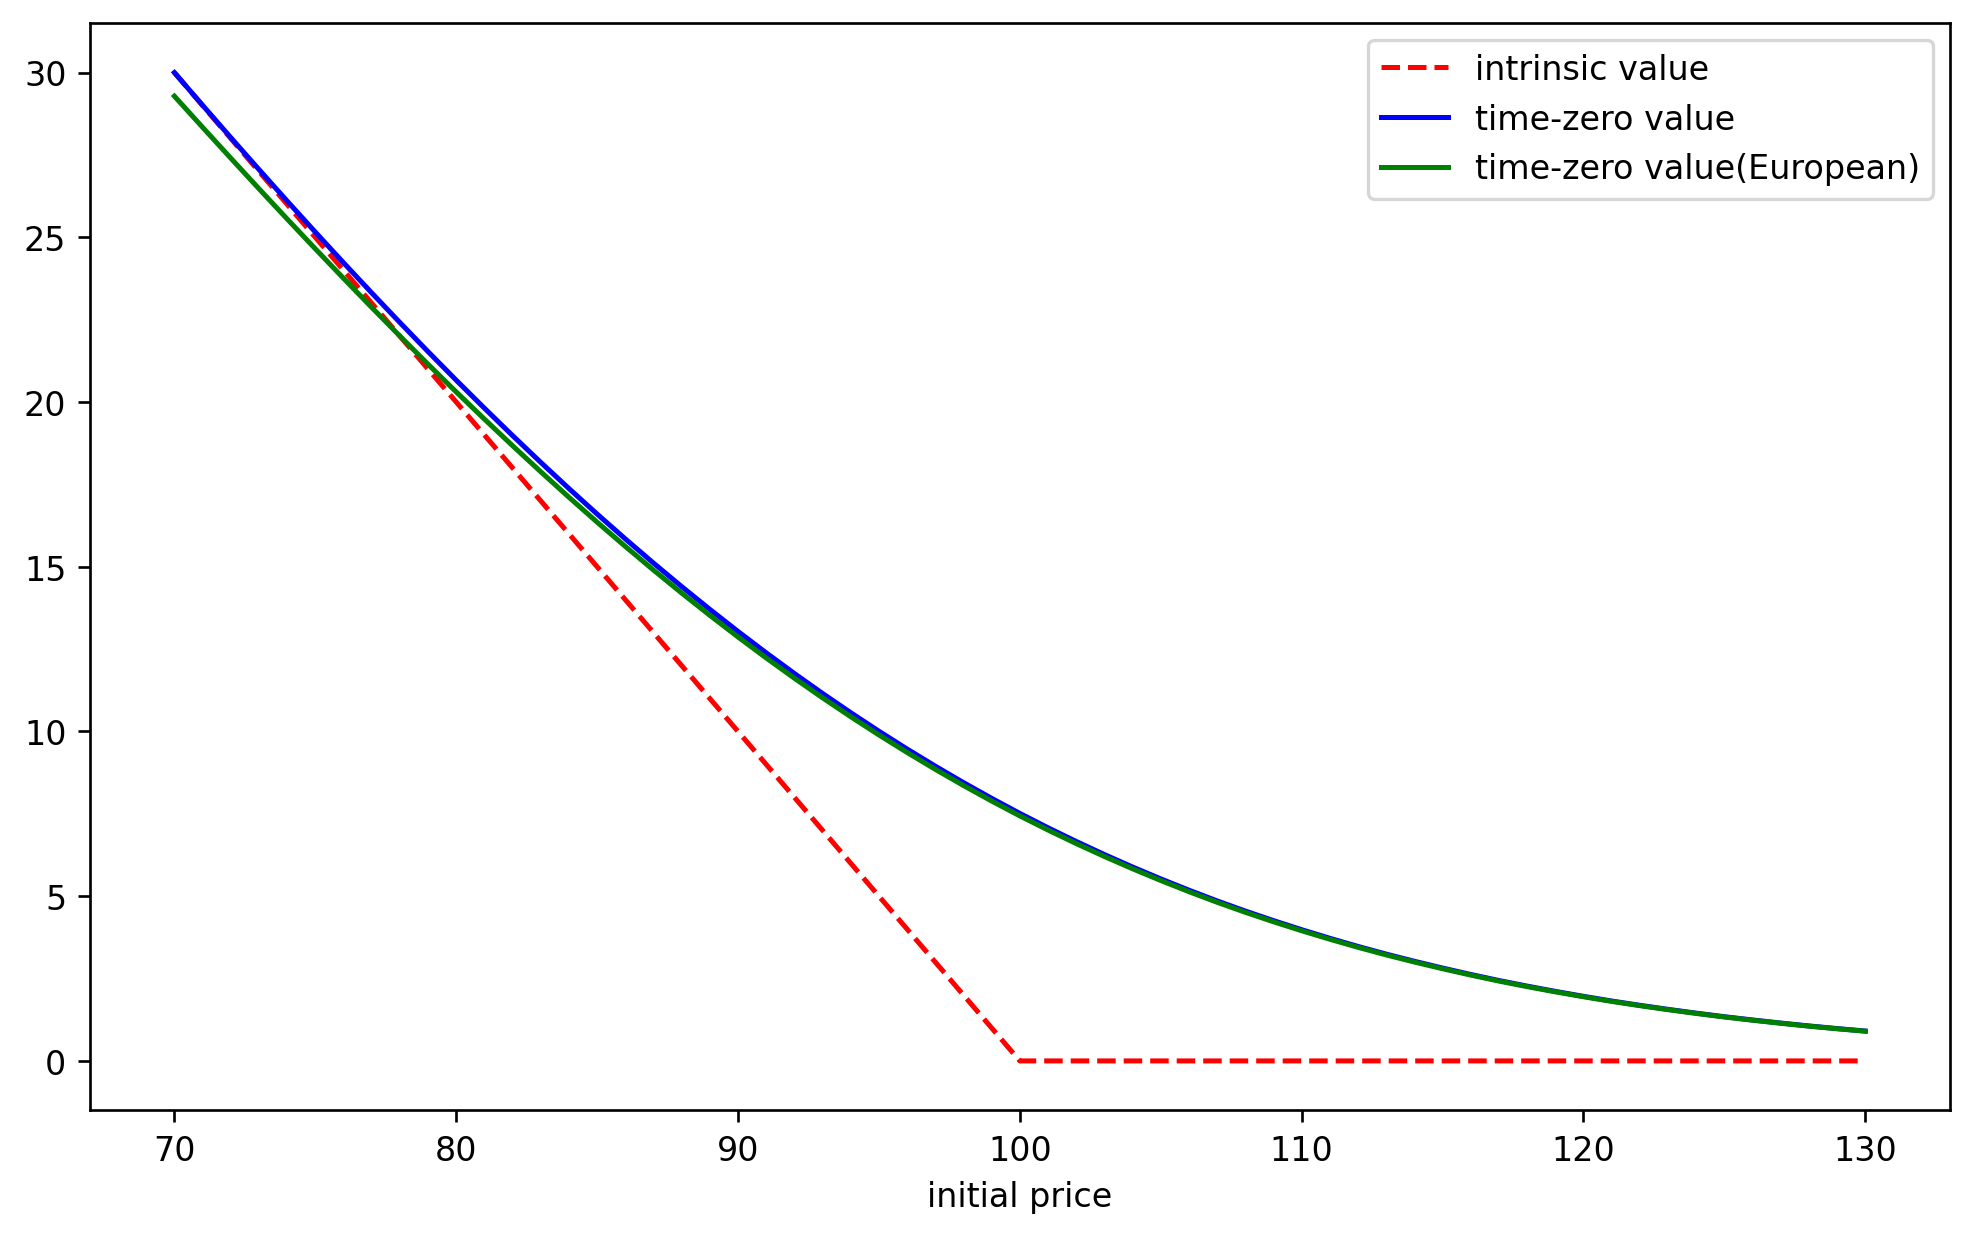

In [22]:
conitnuation_value_put = []
conitnuation_value_europut = []
intrinsic_value = [max(strike_price-i,0) for i in range(70,131)]
for price in range(70,131):
    conitnuation_value_put.append(trinomial_matrix_price_put(N,lambda_,price,strike_price,sigma,r))
    conitnuation_value_europut.append(trinomial_matrix_price_europut(N,lambda_,price,strike_price,sigma,r))
plt.plot(range(70,131),intrinsic_value,'r--',label = "intrinsic value")
plt.plot(range(70,131),conitnuation_value_put,'b-',label = "time-zero value")
plt.plot(range(70,131),conitnuation_value_europut,'g-',label = "time-zero value(European)")
plt.xlabel("initial price")
plt.legend()
# plt.savefig("./1.2.c.put.jpg")

### Boundary

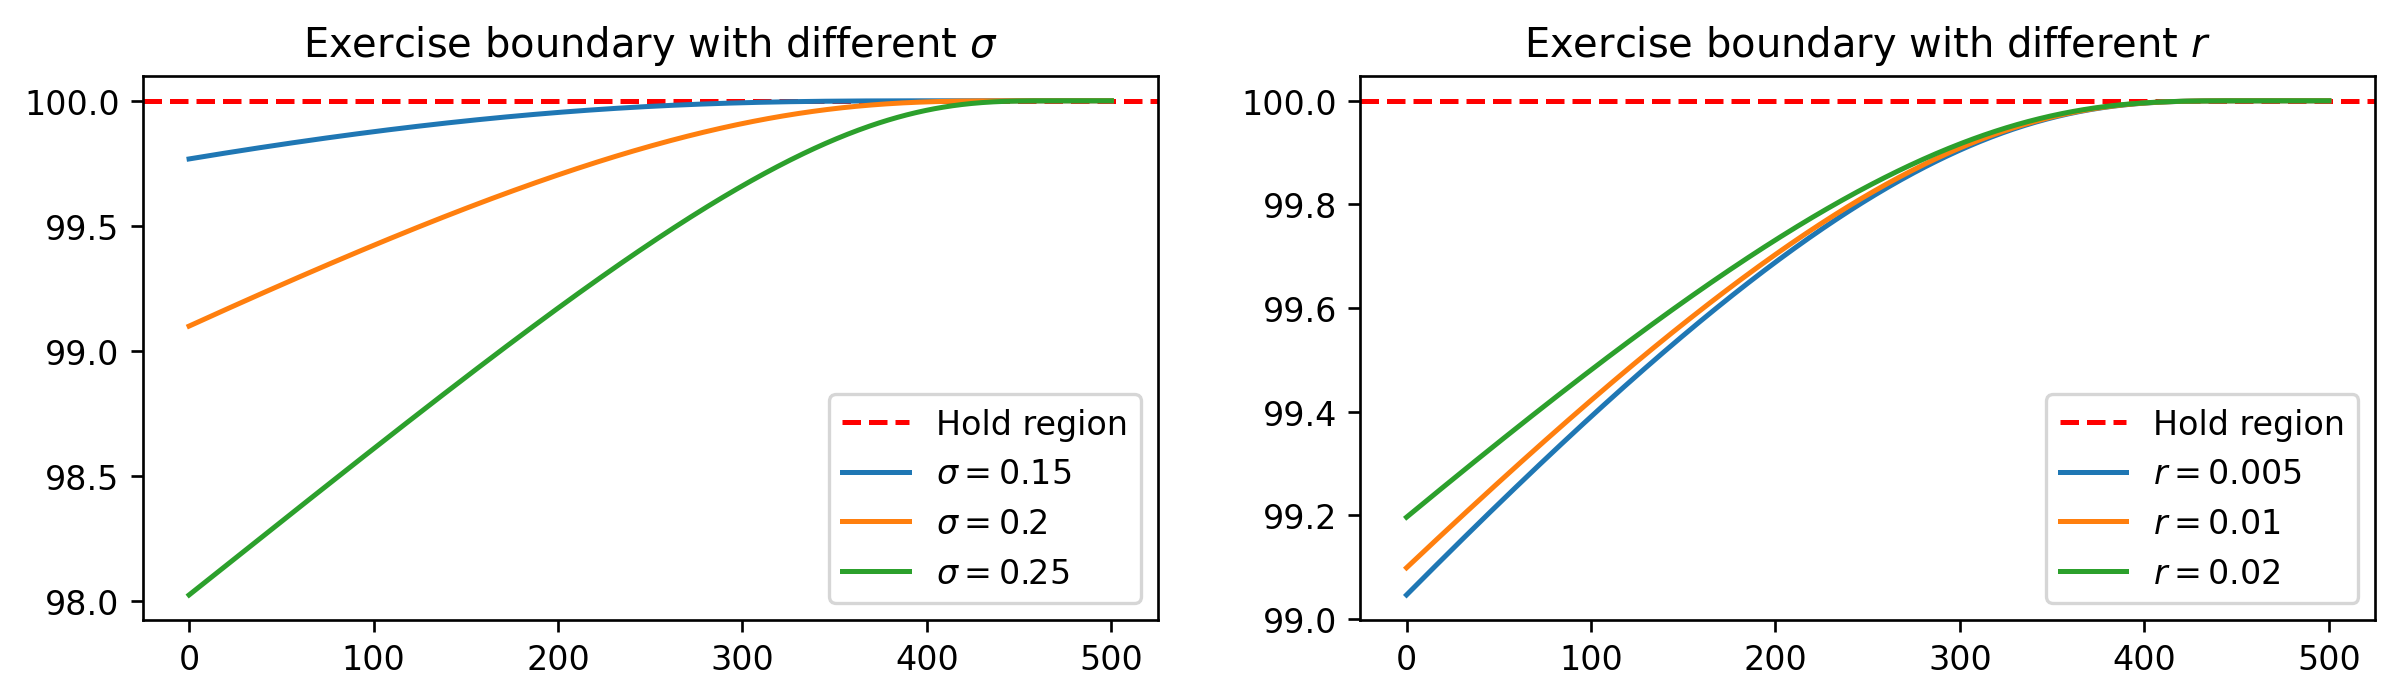

In [23]:
@jit
def boundary(N,lambda_,price,strike_price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    down_factor = 1/up_factor
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    price_matrix = np.zeros((2*N+1,N+1)) # stock price
    V = np.zeros((2*N+1,N+1)) # option price
    # genreate stock price
    for c in range(N+1):
        price_matrix[:2*c+1,c] = price * (up_factor**c) * (down_factor**np.arange(0,2*c+1))
    # final payoff
    V[:,-1] = np.maximum(strike_price-price_matrix[:,-1],0)
    for col in range(N-1,-1,-1):
        V[:2*col+1,col] = discounted_factor*(q_u * V[0:2*col+1,col+1] + q_m * V[1:2*col+2,col+1] + q_d * V[2:2*col+3,col+1])
    boundary = strike_price-V
    return [boundary[i,i] for i in range(N+1)]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].axhline(y = strike_price, color = 'r', linestyle = '--',label="Hold region")
axes[0].plot(boundary(500,lambda_,price,strike_price,sigma-0.05,r),label="$\sigma=0.15$")
axes[0].plot(boundary(500,lambda_,price,strike_price,sigma,r),label="$\sigma=0.2$")
axes[0].plot(boundary(500,lambda_,price,strike_price,sigma+0.05,r),label="$\sigma=0.25$")
axes[0].set_title("Exercise boundary with different $\sigma$")
axes[0].legend()

axes[1].axhline(y = strike_price, color = 'r', linestyle = '--',label="Hold region")
axes[1].plot(boundary(500,lambda_,price,strike_price,sigma,r/2),label="$r=0.005$")
axes[1].plot(boundary(500,lambda_,price,strike_price,sigma,r),label="$r=0.01$")
axes[1].plot(boundary(500,lambda_,price,strike_price,sigma,r*2),label="$r=0.02$")
axes[1].set_title("Exercise boundary with different $r$")
axes[1].legend()
fig.savefig("./boundary.jpg")

In [24]:
l1 = [] # r
l2 = [] # sigma
for r_ in [0.01,0.03,0.05]:
    tmp1 = []
    for price_ in tqdm(l:=range(70,131)):
        tmp1.append(trinomial_matrix_price_put(N,lambda_,price_,strike_price,sigma,r_))
    l1.append(tmp1)
    
for sigma_ in [0.15,0.2,0.25]:
    tmp2 = []
    for price_ in tqdm(l:=range(70,131)):
        tmp2.append(trinomial_matrix_price_put(N,lambda_,price_,strike_price,sigma_,r))
    l2.append(tmp2)

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 222.52it/s]


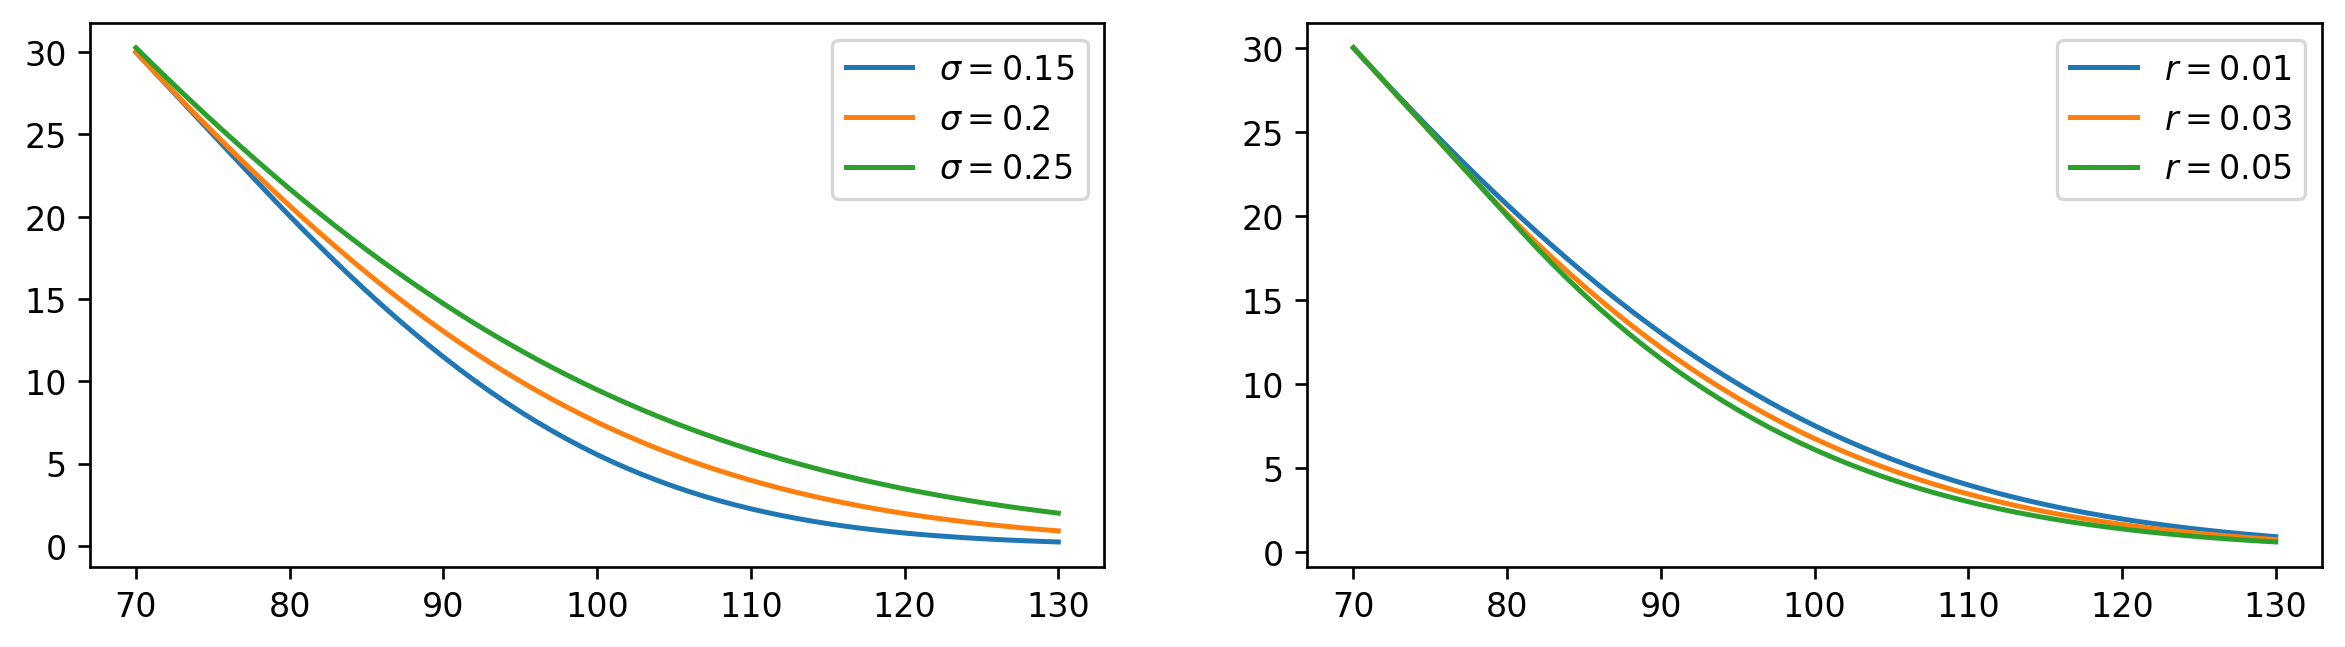

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].plot(l,l2[0],label="$\sigma=0.15$")
axes[0].plot(l,l2[1],label="$\sigma=0.2$")
axes[0].plot(l,l2[2],label="$\sigma=0.25$")
# axes[0].set_title("Exercise boundary with different $\sigma$")
axes[0].legend()

axes[1].plot(l,l1[0],label="$r=0.01$")
axes[1].plot(l,l1[1],label="$r=0.03$")
axes[1].plot(l,l1[2],label="$r=0.05$")
# axes[1].set_title("Exercise boundary with different $r$")
axes[1].legend()
fig.savefig("./optimal.jpg")

## Method 2 for American put option

# Look back option

## Algorithm (European case)

*  Define the following 

$s^n_k=S_0u^nd^k$, $n=0,1,...,N;k=0,1,...,2n$. This is defined in question 1

$m_j^n = S_0u^{n-j}$ $n=0,1,...,N;j=0,1,...,n$. This is the j-th possible value of $\max S_n$  
Note that we have $m_j^n>s^n_k$, hence, we have the relation $j<k$.

* Generate the payoff at time N  


loop k = 0,1,...,2N  
loop j = 0,1,...,min(N,k)  
Compute $V^N_{k,j} = m_j^n-s^n_k$

* Indexing the two variables 

For each $k_{new}$, we have the following

$$\begin{aligned}
m^{n+1}_{j_{new}}& = \max (m_j^n,s^{n+1}_{k_{new}})\\
n+1-j_{new} & = \max(n-j,n+1-k_{new}) \\
j_{new} &= n+1+\min(j-n,k_{new}-(n+1))\\
&=\min(j+1,k_{new})=:\phi(j,k_{new})
\end{aligned}$$

* Loop backward in time


loop n = N-1,...,0  
loop k = 0,1,...,2n  
loop j = 0,1,...,min(n,k)  
Compute
$V^n_{k,j}=e^{-r\Delta t}\left[q_uV^{n+1}_{k,\phi(k,j)} + q_mV^{n+1}_{k+1,\phi(k+1,j)}+q_dV^{n+1}_{k+2,\phi(k+2,j)}\right],$   
where $\phi(k,j) = \min(k,j+1)$

For the case of American style option, we need generate a payoff matrix at $n=0,1,...,N$, and compare the continuation value and intrinsic value in backward looping.

### Lookback European put

Although we could utilize numba to enhance the performance of the code even without vectorization, we will refrain from doing so to demonstrate that the time and memory complexity follows a polynomial growth pattern of degree 3.

In [26]:
N,lambda_,price = 100,1.25,100
# @jit
def eur_lookback_matrix_price(N,lambda_,price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    V = np.zeros((N+1,2*N+1,N+1)) # option price
    # final payoff
    for k in range(2*N+1):
        for j in range(min(k,N)+1):
            V[N,k,j] = price * (up_factor**(N-j)-up_factor**(N-k))
            
    phi = lambda k_new,j:min(k_new,j+1)
    for n in range(N-1,-1,-1):
        for k in range(2*n+1):
            for j in range(min(k,n)+1): 
                V[n,k,j] = discounted_factor * (q_u * V[n+1,k,phi(k,j)] + q_m * V[n+1,k+1,phi(k+1,j)] + q_d * V[n+1,k+2,phi(k+2,j)])
    return V[0,0,0]
eur_lookback_matrix_price(N,lambda_,price,sigma,r)

15.020893787026388

### Lookback American put

In [27]:
N,lambda_,price = 100,1.25,100
# @jit
def ame_lookback_matrix_price(N,lambda_,price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    V = np.zeros((N+1,2*N+1,N+1)) # option price / payoff
    # payoff
    for n in range(N,-1,-1):
        for k in range(2*n+1):
            for j in range(min(k,n)+1):
                V[n,k,j] = price * (up_factor**(n-j)-up_factor**(n-k))
                
    phi = lambda k_new,j:min(k_new,j+1)
    for n in range(N-1,-1,-1):
        for k in range(2*n+1):
            for j in range(min(k,n)+1): 
                V[n,k,j] = max(V[n,k,j],discounted_factor * (q_u * V[n+1,k,phi(k,j)] + q_m * V[n+1,k+1,phi(k+1,j)] + q_d * V[n+1,k+2,phi(k+2,j)]))
               
    return V[0,0,0]
ame_lookback_matrix_price(N,lambda_,price,sigma,r)

15.156875356232318

## Vectorization

In [28]:
N,lambda_,price = 100,1.25,100
def eur_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    V = np.zeros((N+1,2*N+1,N+1)) # option price
    
    # final payoff
    j = np.arange(1, N+1)
    k = np.arange(0, 2*N+1)
    j, k = np.meshgrid(j, k, indexing='ij')
    V[N, k, j] = price * (up_factor**(N-j) - up_factor**(N-k))
    
    # shooting function
    a,b = np.meshgrid(range(2*N+1),range(N+1),indexing='ij')
    phi = np.minimum(a,b+1)

    for n in range(N-1,-1,-1):
        k = np.arange(2*n+1)
        j_min = np.minimum(k,n)
        V[n,k,j_min[:, np.newaxis]] = discounted_factor * (q_u * V[n+1,k,phi[k,j_min[:, np.newaxis]]] + q_m * V[n+1,k+1,phi[k+1,j_min[:, np.newaxis]]] + q_d * V[n+1,k+2,phi[k+2,j_min[:, np.newaxis]]])

    return V[0,0,0]
eur_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r)

15.020893787026388

In [29]:
%timeit eur_lookback_matrix_price(N,lambda_,price,sigma,r)

649 ms ± 5.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit eur_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r)

44.9 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
N,lambda_,price = 100,1.25,100
def ame_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r):
    # recall the parameter 
    dt = 1/N
    up_factor = np.exp(lambda_ * sigma * np.sqrt(dt))
    q_u = 1/(2*lambda_**2) + ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    q_m = 1-1/(lambda_**2)
    q_d = 1/(2*lambda_**2) - ((r-0.5*sigma**2)*np.sqrt(dt))/(2*lambda_*sigma)
    discounted_factor = np.exp(-r*dt)
    V = np.zeros((N+1,2*N+1,N+1)) # option price / payoff
    
    # final payoff
    for n in range(N,-1,-1):
        j = np.arange(1, n+1)
        k = np.arange(0, 2*n+1)
        j, k = np.meshgrid(j, k, indexing='ij')
        V[n, k, j] = price * (up_factor**(n-j) - up_factor**(n-k))

    # shooting function
    a,b = np.meshgrid(range(2*N+1),range(N+1),indexing='ij')
    phi = np.minimum(a,b+1)
    
    for n in range(N-1,-1,-1):
        k = np.arange(2*n+1)
        j_min = np.minimum(k,n)
        discounted_V = discounted_factor * (q_u * V[n+1,k,phi[k,j_min[:, np.newaxis]]] + q_m * V[n+1,k+1,phi[k+1,j_min[:, np.newaxis]]] + q_d * V[n+1,k+2,phi[k+2,j_min[:, np.newaxis]]])
        V[n,k,j_min[:, np.newaxis]] = np.maximum(V[n,k,j_min[:, np.newaxis]], discounted_V)
              
    return V[0,0,0]
ame_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r)

15.156875356232318

In [32]:
%timeit ame_lookback_matrix_price(N,lambda_,price,sigma,r)

1.07 s ± 12.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
%timeit ame_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r)

88.4 ms ± 208 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
tmp_eur = []
tmp_ame = []
x_ = range(100,550,50)  
for N in tqdm(x_):
    tmp_eur.append(eur_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r))
    tmp_ame.append(ame_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r))

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.10s/it]


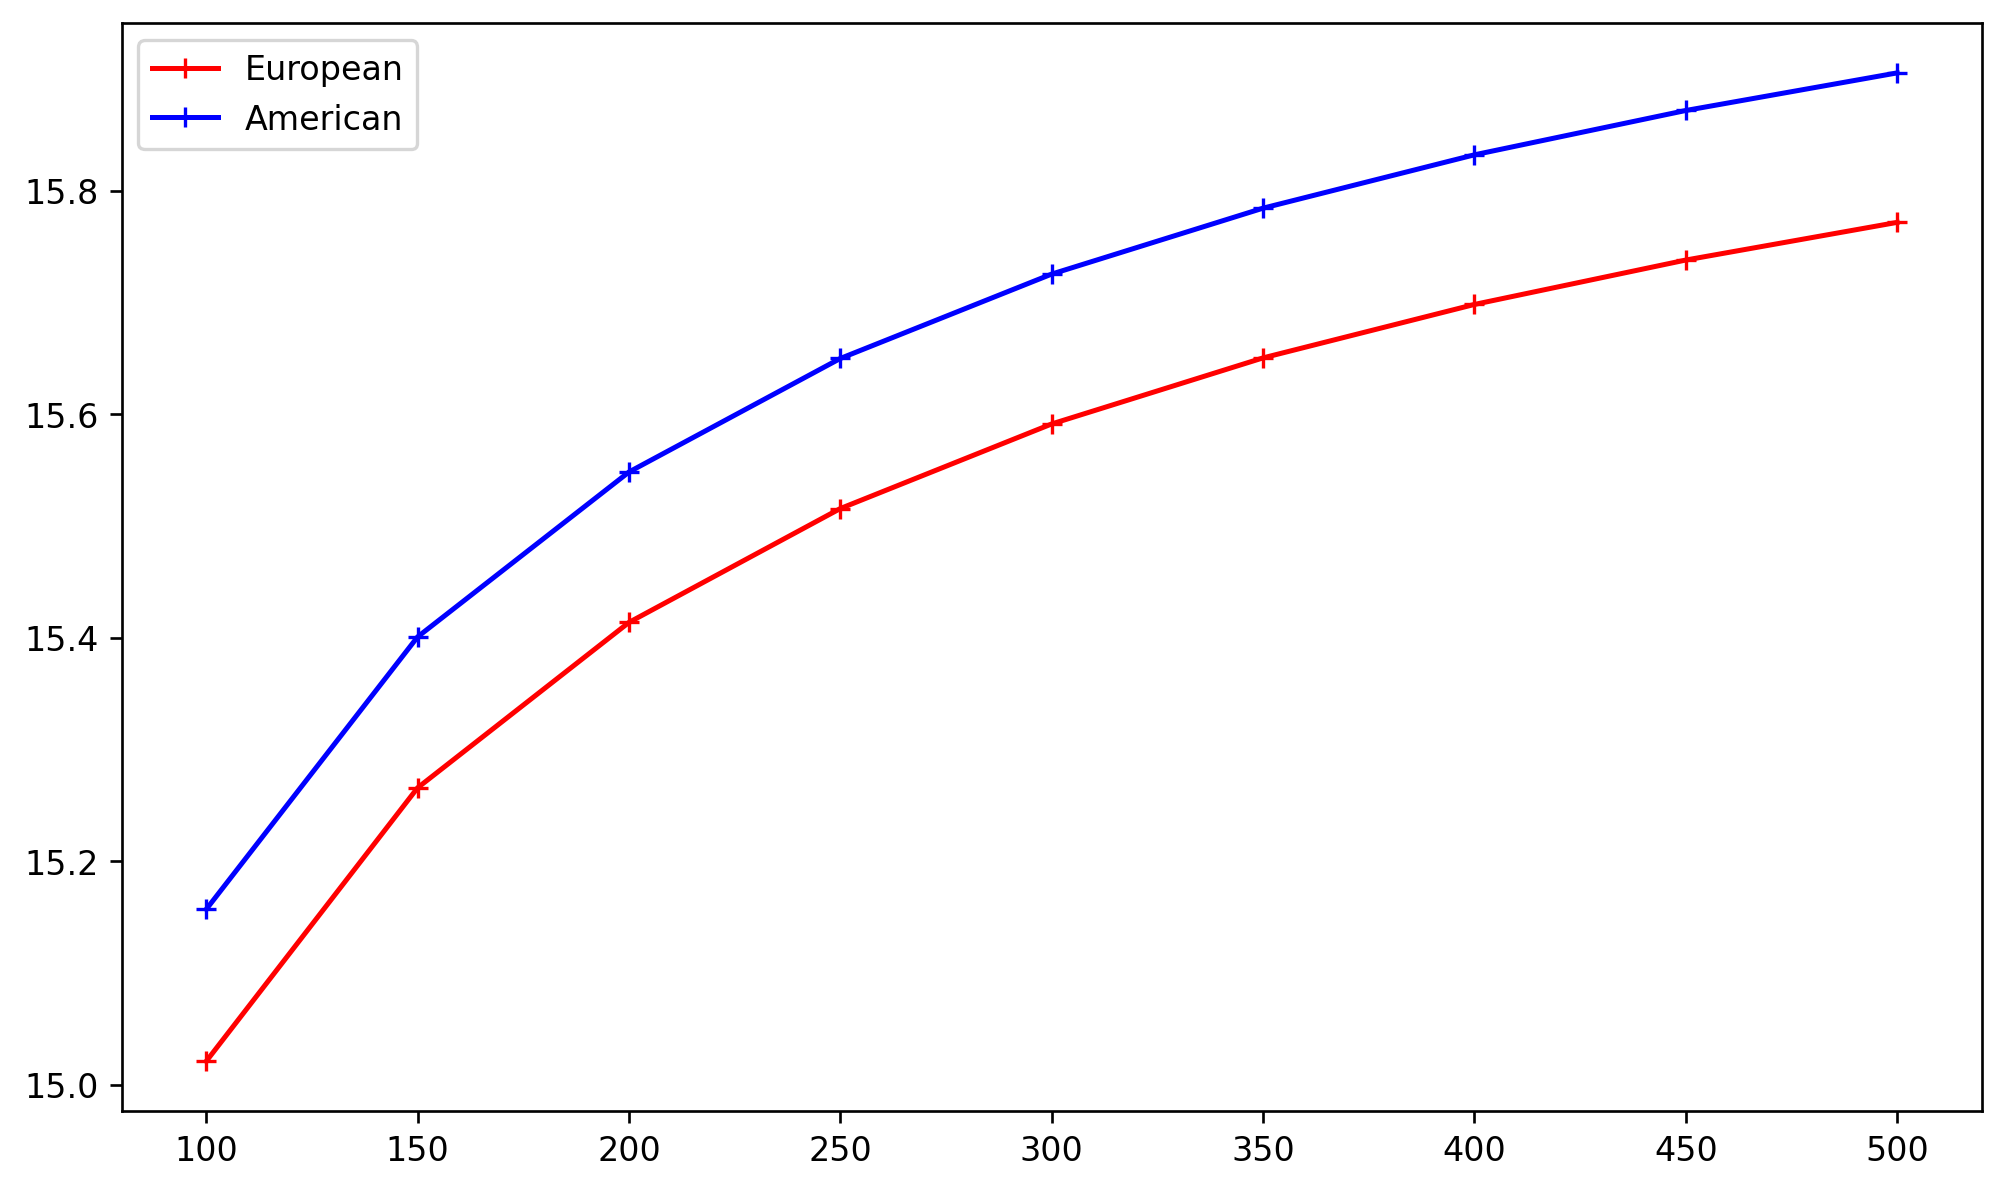

In [35]:
plt.plot(x_,tmp_eur,"r+-",label = "European")
plt.plot(x_,tmp_ame,"b+-",label = "American")
plt.legend()
# plt.savefig("./1.3.b.1.jpg")

### European case

In [36]:
t = []
t_vec = []
x = range(5,120)
for N in tqdm(x):
    start = time.time()
    eur_lookback_matrix_price(N,lambda_,price,sigma,r)
    end = time.time()
    t.append(end-start)
    
    start = time.time()
    eur_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r)
    end = time.time()
    t_vec.append(end-start)
coefficient = np.polynomial.polynomial.Polynomial.fit(x,t,3)
fitted = coefficient(x)
coefficient_vec = np.polynomial.polynomial.Polynomial.fit(x,t_vec,3)
fitted_vec = coefficient_vec(x)
coefficient_2 = np.polynomial.polynomial.Polynomial.fit(x,t,2)
fitted_2 = coefficient_2(x)
coefficient_2_vec = np.polynomial.polynomial.Polynomial.fit(x,t_vec,2)
fitted_2_vec = coefficient_2_vec(x)

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:35<00:00,  3.26it/s]


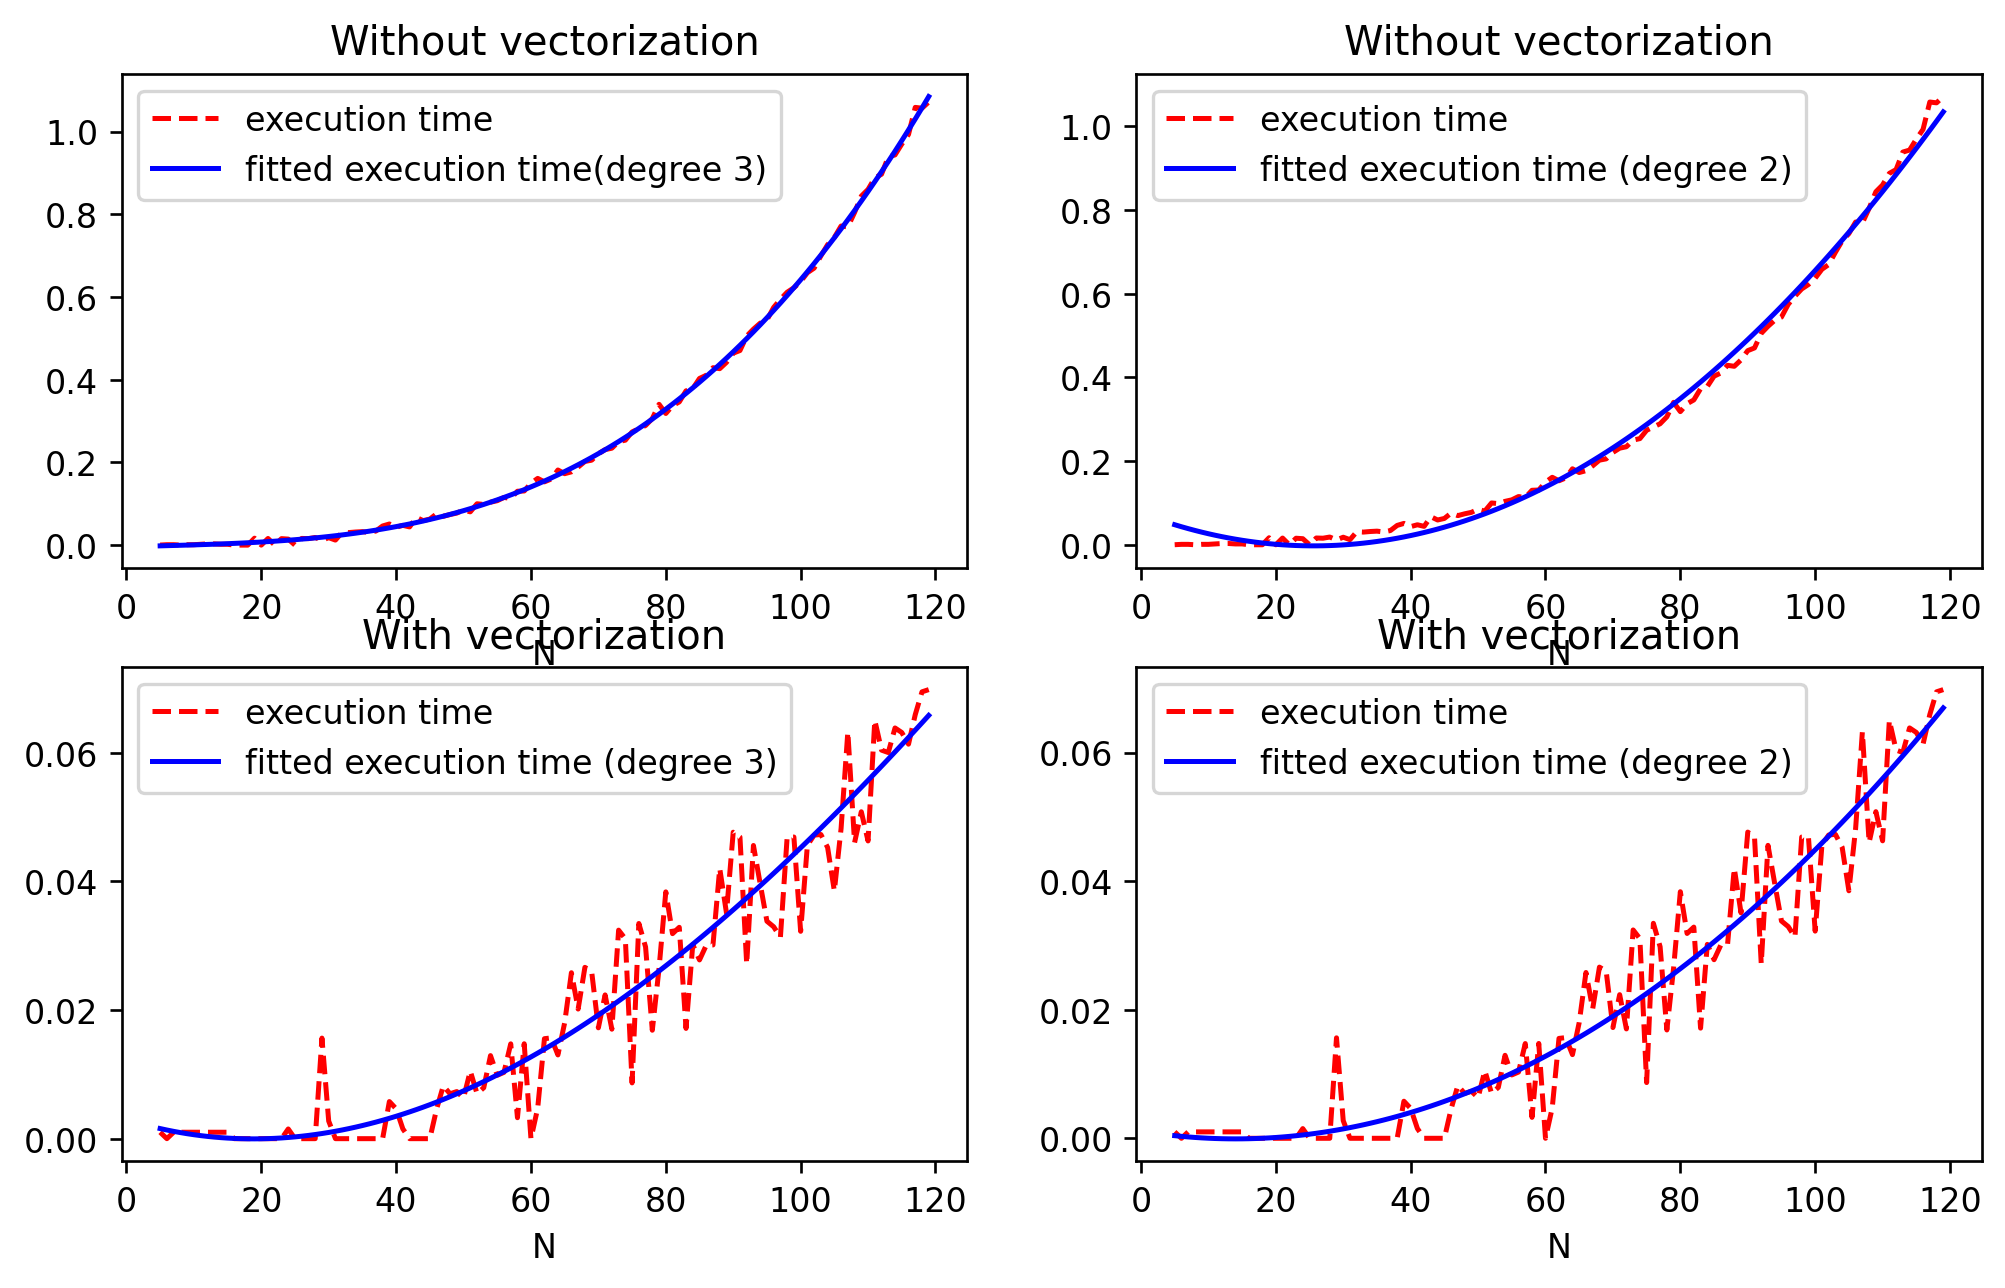

In [37]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(x,t,'r--',label="execution time")
ax1.plot(x,fitted,'b-',label="fitted execution time(degree 3)")
ax1.set_xlabel('N')
ax1.set_title("Without vectorization")
plt.legend()

ax2 = fig.add_subplot(222)
ax2.plot(x, t, 'r--', label="execution time")
ax2.plot(x, fitted_2, 'b-', label = "fitted execution time (degree 2)") 
ax2.set_xlabel('N')
ax2.set_title("Without vectorization")
plt.legend()

ax3 = fig.add_subplot(223)
ax3.plot(x, t_vec, 'r--', label="execution time")
ax3.plot(x, fitted_vec, 'b-', label = "fitted execution time (degree 3)") 
ax3.set_xlabel('N')
ax3.set_title("With vectorization")
plt.legend()

ax4 = fig.add_subplot(224)
ax4.plot(x, t_vec, 'r--', label="execution time")
ax4.plot(x, fitted_2_vec, 'b-', label = "fitted execution time (degree 2)") 
ax4.set_xlabel('N')
ax4.set_title("With vectorization")
plt.legend()

plt.show()
# fig.savefig("./1.3.b.eur.jpg")

### American case

In [38]:
t = []
t_vec = []
x = range(5,120)
for N in tqdm(x):
    start = time.time()
    ame_lookback_matrix_price(N,lambda_,price,sigma,r)
    end = time.time()
    t.append(end-start)
    
    start = time.time()
    ame_lookback_matrix_price_vectorization(N,lambda_,price,sigma,r)
    end = time.time()
    t_vec.append(end-start)
coefficient = np.polynomial.polynomial.Polynomial.fit(x,t,3)
fitted = coefficient(x)
coefficient_vec = np.polynomial.polynomial.Polynomial.fit(x,t_vec,3)
fitted_vec = coefficient_vec(x)
coefficient_2 = np.polynomial.polynomial.Polynomial.fit(x,t,2)
fitted_2 = coefficient_2(x)
coefficient_2_vec = np.polynomial.polynomial.Polynomial.fit(x,t_vec,2)
fitted_2_vec = coefficient_2_vec(x)

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [00:59<00:00,  1.94it/s]


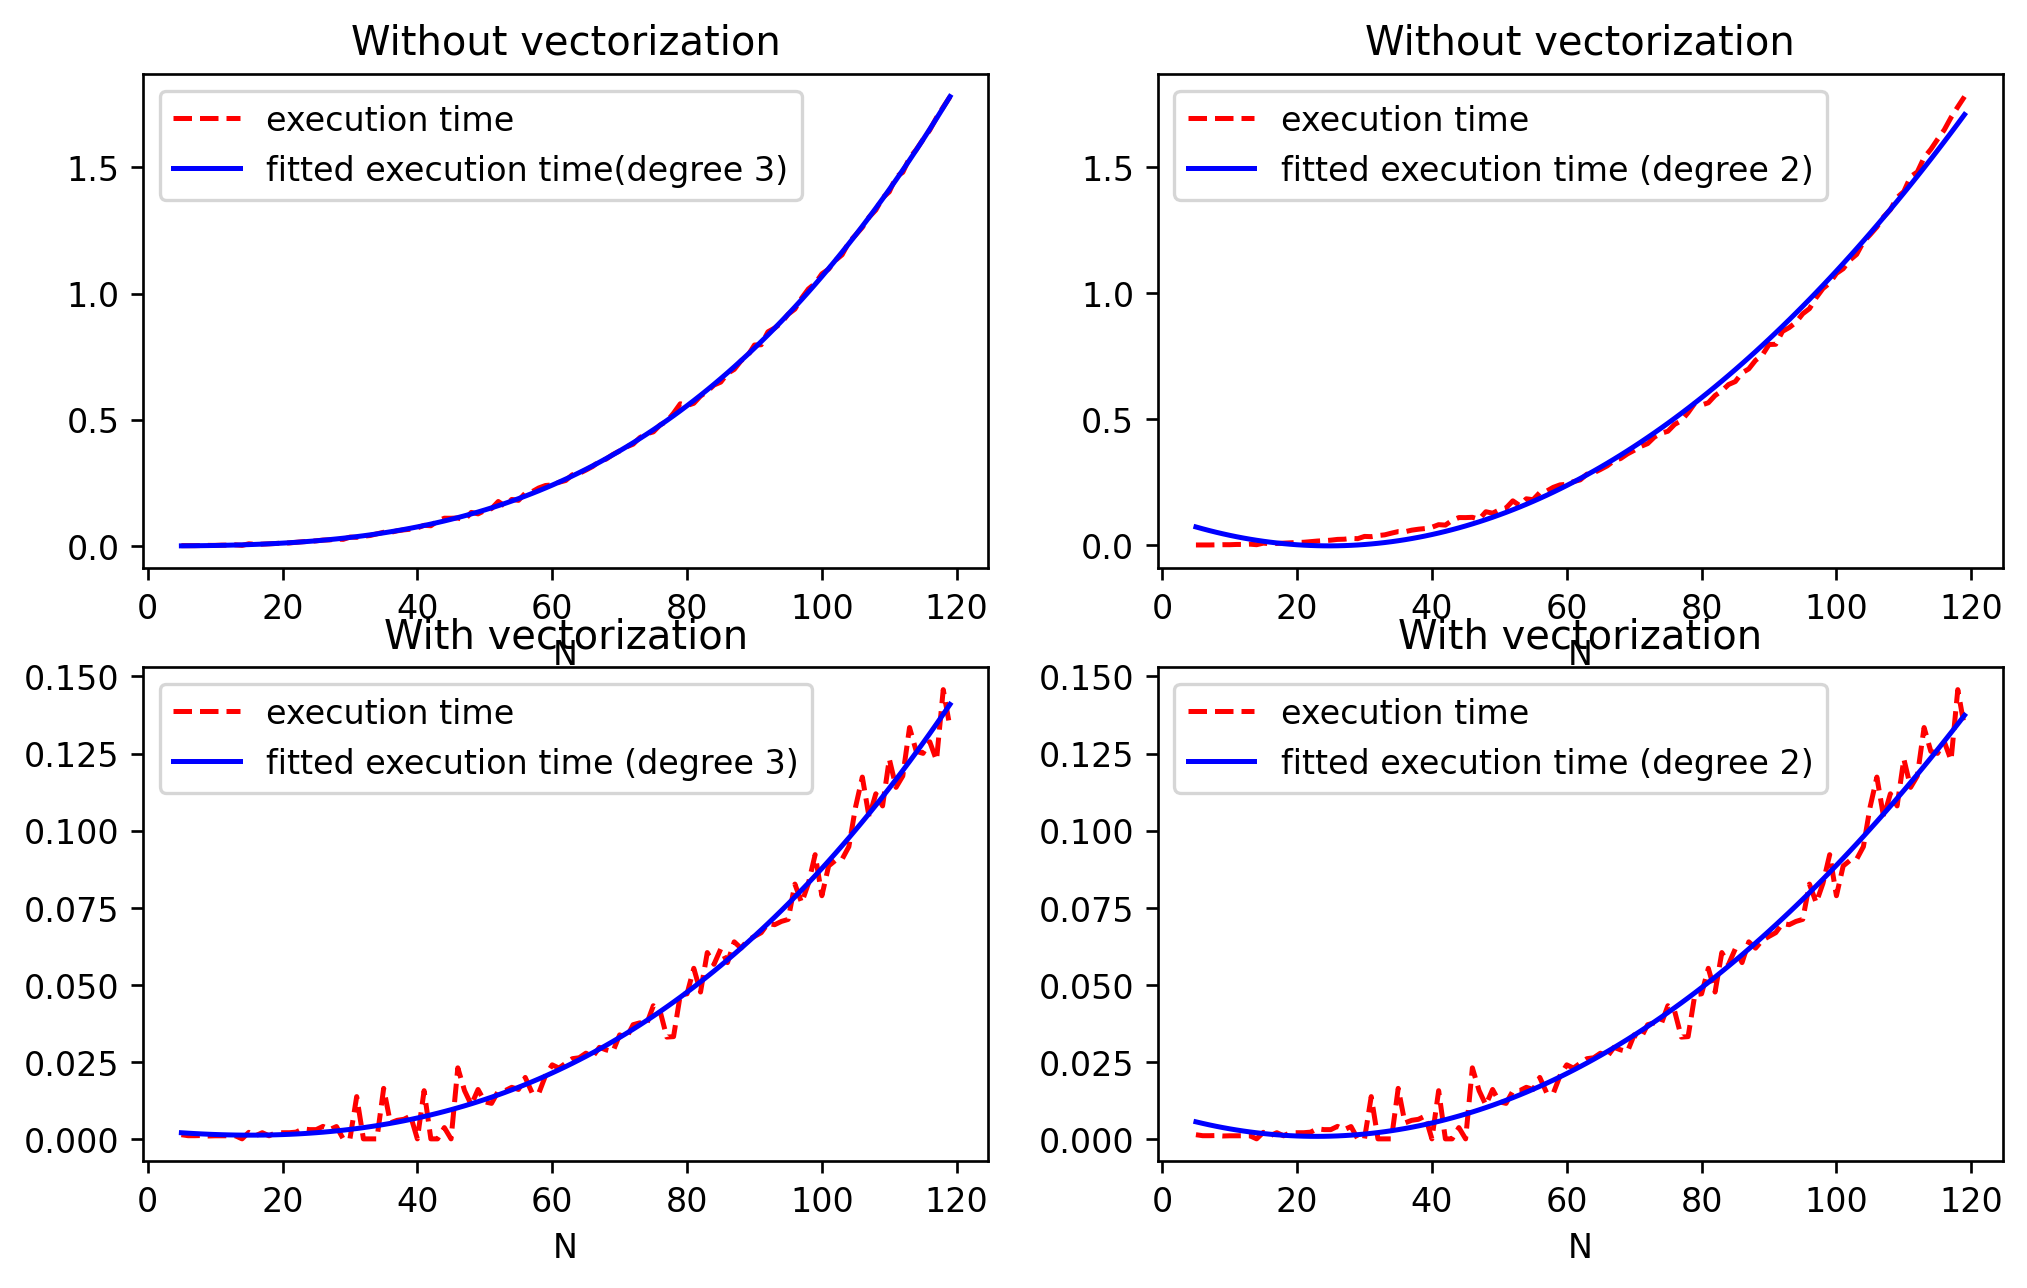

In [39]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.plot(x,t,'r--',label="execution time")
ax1.plot(x,fitted,'b-',label="fitted execution time(degree 3)")
ax1.set_xlabel('N')
ax1.set_title("Without vectorization")
plt.legend()

ax2 = fig.add_subplot(222)
ax2.plot(x, t, 'r--', label="execution time")
ax2.plot(x, fitted_2, 'b-', label = "fitted execution time (degree 2)") 
ax2.set_xlabel('N')
ax2.set_title("Without vectorization")
plt.legend()

ax3 = fig.add_subplot(223)
ax3.plot(x, t_vec, 'r--', label="execution time")
ax3.plot(x, fitted_vec, 'b-', label = "fitted execution time (degree 3)") 
ax3.set_xlabel('N')
ax3.set_title("With vectorization")
plt.legend()

ax4 = fig.add_subplot(224)
ax4.plot(x, t_vec, 'r--', label="execution time")
ax4.plot(x, fitted_2_vec, 'b-', label = "fitted execution time (degree 2)") 
ax4.set_xlabel('N')
ax4.set_title("With vectorization")
plt.legend()

plt.show()
# fig.savefig("./1.3.b.ame.jpg")

### Comparison

In [40]:
t_eur = []
t_ame = []
x = range(5,120)
for N in tqdm(x):
    start = time.time()
    ame_lookback_matrix_price(N,lambda_,price,sigma,r)
    end = time.time()
    t_ame.append(end-start)
 
    start = time.time()
    eur_lookback_matrix_price(N,lambda_,price,sigma,r)
    end = time.time()
    t_eur.append(end-start)

100%|████████████████████████████████████████████████████████████████████████████████| 115/115 [01:27<00:00,  1.31it/s]


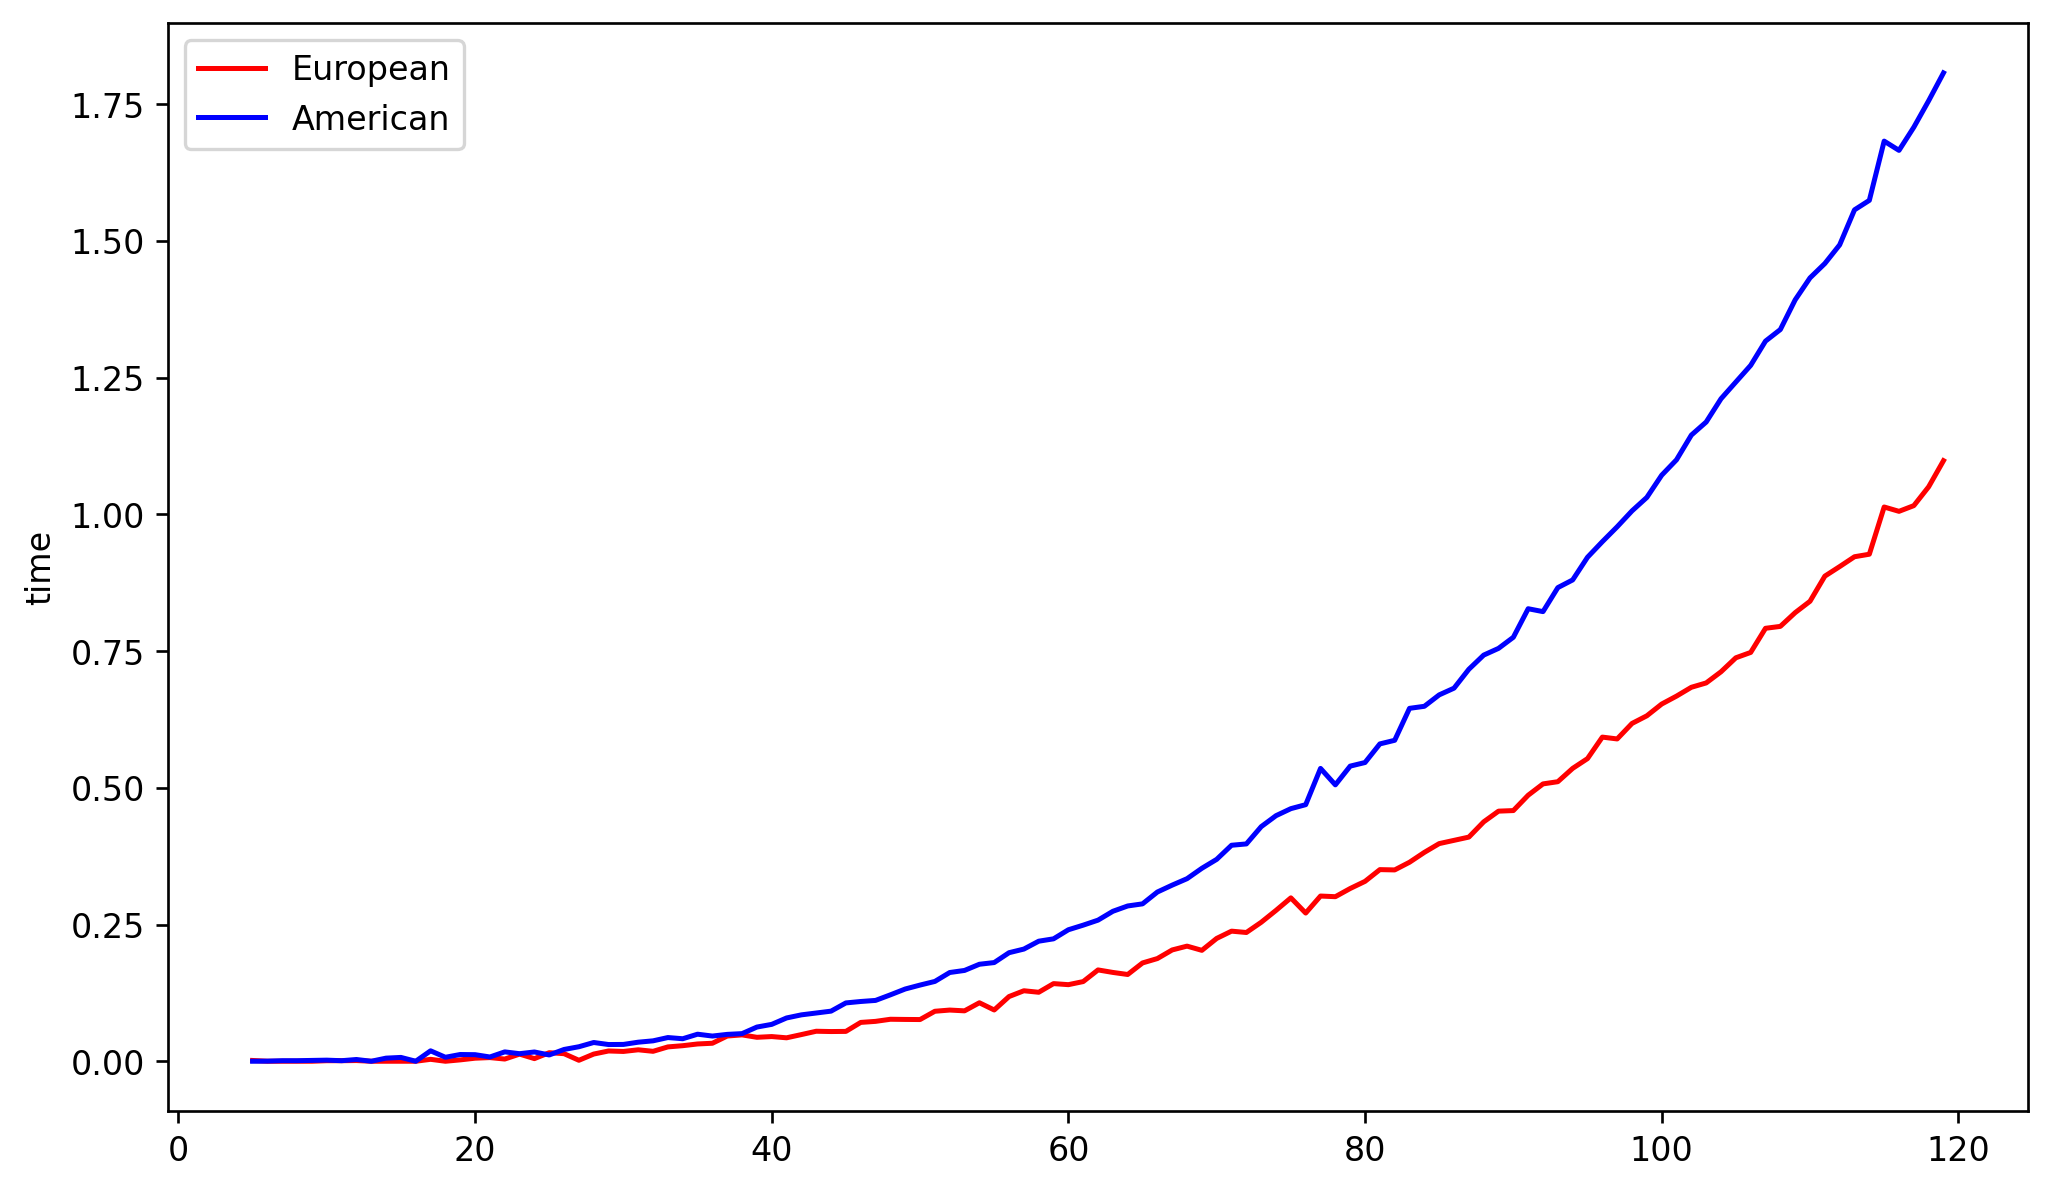

In [41]:
plt.plot(x,t_eur,"r-",label = "European")
plt.plot(x,t_ame,"b-",label = "American")
plt.ylabel("time")
plt.legend()
# plt.savefig("./1.3.b.compare.jpg")

### Theoretical price for European floating lookback put(https://en.wikipedia.org/wiki/Lookback_option)
$M = \max_{0\leq u\leq t}S_u$,$\tau = T-t$, in our question $t=0,M=S_0=S$,$\Phi$ is the standard normal CDF.

\begin{aligned}
& a_1(S, H)=\frac{\ln (S / H)+\left(r+\frac{1}{2} \sigma^2\right) \tau}{\sigma \sqrt{\tau}} \\
& a_2(S, H)=\frac{\ln (S / H)+\left(r-\frac{1}{2} \sigma^2\right) \tau}{\sigma \sqrt{\tau}}=a_1(S, H)-\sigma \sqrt{\tau} \\
& a_3(S, H)=\frac{\ln (S / H)-\left(r-\frac{1}{2} \sigma^2\right) \tau}{\sigma \sqrt{\tau}}=a_1(S, H)-\frac{2 r \sqrt{\tau}}{\sigma}, \text { with } H>0, S>0,
\end{aligned}
The price of the lookback put option with floating strike is given by,
$$L P_t=-S \Phi\left(-a_1(S, M)\right)+M e^{-r \tau} \Phi\left(-a_2(S, M)\right)+\frac{S \sigma^2}{2 r}\left(\Phi\left(a_1(S, M)\right)-e^{-r \tau}(M / S)^{\frac{2 r}{\sigma^2}} \Phi\left(a_3(S, M)\right)\right)$$

In [42]:
def BS_lookback(sigma,r,T,price):
    a1 = (r + 0.5 * sigma**2) * T / (sigma * np.sqrt(T))
    a2 = a1 - sigma * np.sqrt(T)
    a3 = a1 - (2 * r * np.sqrt(T)) / sigma
    part1 = -price * norm.cdf(-a1) + price * np.exp(-r*T) * norm.cdf(-a2)
    part2 = norm.cdf(a1) - np.exp(-r*T)*norm.cdf(a3)
    return part1 + part2 * price * sigma**2 / (2*r)

In [43]:
BS_lookback(sigma,r,T,price)

16.408774883070585